In [279]:
!which python 
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python


farshed.abdukhakimov
srv-01
/home/farshed.abdukhakimov/projects/twin-polyak/experiments


In [280]:
%load_ext autoreload
%autoreload 2

import os
import datetime
import time
from collections import defaultdict
import pickle

import numpy as np
import numba

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

import utils
from loss_functions import LogisticRegressionLoss, BaseOracle
from methods import *

import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import scipy
import svmlight_loader

from dotenv import load_dotenv
load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [281]:
def mean_max_min(l):
    max_length = max(len(sublist) for sublist in l)
    
    mean_line = []
    max_line = []
    min_line = []
    for i in range(max_length):
        values_at_position = [sublist[i] for sublist in l if i < len(sublist)]
        mean_line.append(np.mean(values_at_position))
        max_line.append(np.max(values_at_position))
        min_line.append(np.min(values_at_position))

    return mean_line, max_line, min_line

def plotter_seeds(histories, labels, 
                  colors=list(plt.cm.colors.XKCD_COLORS.keys()) + list(plt.cm.colors.BASE_COLORS), 
                  linestyles=["-" for _ in range(20)], 
                  linewidths=[1.5 for _ in range(20)], 
                  markers=[" " for _ in range(20)], 
                  markeredgecolor="dimgrey", 
                  markersize=8, 
                  alphas=[1.0 for _ in range(20)], 
                  f_star=None, suptitle=None, 
                  metrics=["train/loss", "train/grad_norm_sq", "train/acc", "lr"], y_scales=["log", "log", "linear", "log"],
                  mov_ave=[False for _ in range(20)],
                  x_labels=None, y_labels=None, x_labels_fs=16, y_labels_fs=16,
                  acc_ylim=None,
                  threshold=1e-10, xlims=None, tight_layout=True, legend_below=False,
                  filename=None):
    
    fig, ax = plt.subplots(1, len(metrics), figsize=(len(metrics) * 4, 4))
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
    
    for history, label, c, ls, lw, m, alpha in zip(histories, labels, colors, linestyles, linewidths, markers, alphas):
        
        steps_per_epoch = len(history[0]["lr"]) / len(history[0]["train/loss"])
        
        for (ax_idx, metric), apply_ma in zip(enumerate(metrics), mov_ave):
            
            if metric in ["train/loss", "test/loss"]:
                if apply_ma:
                    res = [utils.moving_average(x[metric] - f_star, len(x[metric]) // 10) for x in history]
                else:
                    res = [x[metric] - f_star for x in history]
            else:
                if apply_ma:
                    res = [utils.moving_average(x[metric], len(x[metric]) // 10) for x in history]
                else:
                    res = [x[metric] for x in history]
            
            mean_line, max_line, min_line = mean_max_min(res)
            if metric == "lr":
                x = np.linspace(0, len(mean_line)/steps_per_epoch - 1, len(mean_line))
            else:
                x = np.linspace(0, len(mean_line) - 1, len(mean_line))
                
            # if metric == "lr":
            #     markevery = [0,] + [x + np.random.randint(0, 25) for x in range(0, len(mean_line) - 25, len(mean_line) // 10)]
            # else:
            markevery = [0,] + [x + np.random.randint(0, 10) for x in range(len(mean_line) // 5, len(mean_line) - 10, len(mean_line) // 5)]
                
            
            lbl = None
            if ax_idx == len(metrics) - 1:
                lbl = label
                
            ax[ax_idx].fill_between(x, max_line, min_line, color=c, alpha=0.2)
            ax[ax_idx].plot(x, mean_line, label=lbl, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)   
            ax[ax_idx].set_yscale(y_scales[ax_idx])
            
            if metric == "test/acc" and acc_ylim:
                ax[ax_idx].set_ylim(bottom=acc_ylim)

            
            # if alpha != 1.0:
            #     ax[3].semilogy(history["lr"], linestyle=ls, linewidth=lw, color=c, alpha=alpha)
            #     ax[3].semilogy(moving_average(history["lr"], 100), linestyle=ls, linewidth=lw, color=c, alpha=1.0, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)
            # else:
            #     ax[3].semilogy(history["lr"], linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)

    for i, xlabel, ylabel in zip(range(4), x_labels, y_labels):
        ax[i].set_xlabel(xlabel, fontsize=x_labels_fs)
        ax[i].set_ylabel(ylabel, fontsize=y_labels_fs)
        ax[i].grid()
    
    if xlims is not None:
        ax[1].set_xlim(right=xlims[1])
    
    if legend_below:
        # Put a legend below current axis
        fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.02), fancybox=True, shadow=True, ncol=len(histories))
    else:
        fig.legend()
    
    
    if tight_layout:
        fig.tight_layout()
        
    if filename is not None:
        directory = "plots/" + datetime.datetime.today().strftime("%d-%m-%Y")
        if not os.path.exists(directory):
            os.makedirs(directory)
        fig.savefig(directory + "/" + filename)
    else:
        fig.show()
        
        
def plotter_seeds_one_plot(histories, labels, 
                  colors=list(plt.cm.colors.XKCD_COLORS.keys()) + list(plt.cm.colors.BASE_COLORS), 
                  linestyles=["-" for _ in range(20)], 
                  linewidths=[1.5 for _ in range(20)], 
                  markers=[" " for _ in range(20)], 
                  markeredgecolor="dimgrey", 
                  markersize=8, 
                  alphas=[1.0 for _ in range(20)], 
                  f_star=None, suptitle=None, 
                  metric="train/loss", y_scale="linear",
                  x_label=None, y_label=None, x_labels_fs=16, y_labels_fs=16,
                  threshold=1e-10, xlims=None, tight_layout=True, 
                  filename=None):
    
    fig = plt.figure(figsize=(4, 4))
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
    
    for history, label, c, ls, lw, m, alpha in zip(histories, labels, colors, linestyles, linewidths, markers, alphas):
        
        if metric in ["train/loss", "test/loss"]:
            res = [utils.moving_average(x[metric] - f_star, len(x[metric]) // 10) for x in history]
        else:
            res = [utils.moving_average(x[metric], len(x[metric]) // 10) for x in history]
        
        mean_line, max_line, min_line = mean_max_min(res)
        x = np.linspace(0, len(mean_line) - 1, len(mean_line))
        markevery = [0,] + [x + np.random.randint(0, 5) for x in range(0, len(mean_line) - 5, len(mean_line) // 10)]
        plt.fill_between(x, max_line, min_line, color=c, alpha=0.2)
        plt.plot(x, mean_line, label=label, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)   
        plt.yscale(y_scale)
            

    plt.xlabel(x_label, fontsize=x_labels_fs)
    plt.ylabel(y_label, fontsize=y_labels_fs)
    plt.grid()
    
    fig.legend()
    
    if tight_layout:
        fig.tight_layout()
        
    if filename is not None:
        directory = "plots/" + datetime.datetime.today().strftime("%d-%m-%Y")
        if not os.path.exists(directory):
            os.makedirs(directory)
        fig.savefig(directory + "/" + filename)
    else:
        fig.show()

In [282]:
def plotter_seeds_r(histories, labels, 
                  colors=list(plt.cm.colors.XKCD_COLORS.keys()) + list(plt.cm.colors.BASE_COLORS), 
                  linestyles=["-" for _ in range(20)], 
                  linewidths=[1.5 for _ in range(20)], 
                  markers=[" " for _ in range(20)], 
                  markeredgecolor="dimgrey", 
                  markersize=8, 
                  alphas=[1.0 for _ in range(20)], 
                  f_star=None, suptitle=None, 
                  metrics=["train/loss", "train/grad_norm_sq", "train/acc", "lr"], y_scales=["log", "log", "linear", "log"],
                  mov_ave=[False for _ in range(20)],
                  x_labels=None, y_labels=None, x_labels_fs=16, y_labels_fs=16,
                  acc_ylim=None,
                  threshold=1e-10, xlims=None, tight_layout=True, legend_below=False,
                  filename=None):
    
    fig, ax = plt.subplots(len(metrics), 1, figsize=(4, len(metrics) * 4))
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16, y=0.98)
    
    for history, label, c, ls, lw, m, alpha in zip(histories, labels, colors, linestyles, linewidths, markers, alphas):
        
        for (ax_idx, metric), apply_ma in zip(enumerate(metrics), mov_ave):
            
            if metric in ["train/loss", "test/loss"]:
                if apply_ma:
                    res = [utils.moving_average(x[metric] - f_star, len(x[metric]) // 10) for x in history]
                else:
                    res = [x[metric] - f_star for x in history]
            else:
                if apply_ma:
                    res = [utils.moving_average(x[metric], len(x[metric]) // 10) for x in history]
                else:
                    res = [x[metric] for x in history]
            
            mean_line, max_line, min_line = mean_max_min(res)
            x = np.linspace(0, len(mean_line) - 1, len(mean_line))
            if metric == "lr":
                markevery = [0,] + [x + np.random.randint(0, 25) for x in range(0, len(mean_line) - 25, len(mean_line) // 10)]
            else:
                markevery = [0,] + [x + np.random.randint(0, 10) for x in range(0, len(mean_line) - 10, len(mean_line) // 10)]
                
            
            lbl = None
            if ax_idx == len(metrics) - 1:
                lbl = label
                
            ax[ax_idx].fill_between(x, max_line, min_line, color=c, alpha=0.2)
            ax[ax_idx].plot(x, mean_line, label=lbl, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)   
            ax[ax_idx].set_yscale(y_scales[ax_idx])
            
            if metric == "test/acc" and acc_ylim:
                ax[ax_idx].set_ylim(bottom=acc_ylim)

            
            # if alpha != 1.0:
            #     ax[3].semilogy(history["lr"], linestyle=ls, linewidth=lw, color=c, alpha=alpha)
            #     ax[3].semilogy(moving_average(history["lr"], 100), linestyle=ls, linewidth=lw, color=c, alpha=1.0, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)
            # else:
            #     ax[3].semilogy(history["lr"], linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)

    for i, xlabel, ylabel in zip(range(4), x_labels, y_labels):
        ax[i].set_xlabel(xlabel, fontsize=x_labels_fs)
        ax[i].set_ylabel(ylabel, fontsize=y_labels_fs)
        ax[i].grid()
    
    if xlims is not None:
        ax[1].set_xlim(right=xlims[1])
    
    if legend_below:
        # Put a legend below current axis
        fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.02), fancybox=True, shadow=True, ncol=len(histories))
    else:
        fig.legend()
    
    
    if tight_layout:
        fig.tight_layout()
        
    if filename is not None:
        directory = "plots/" + datetime.datetime.today().strftime("%d-%m-%Y")
        if not os.path.exists(directory):
            os.makedirs(directory)
        fig.savefig(directory + "/" + filename)
    else:
        fig.show()

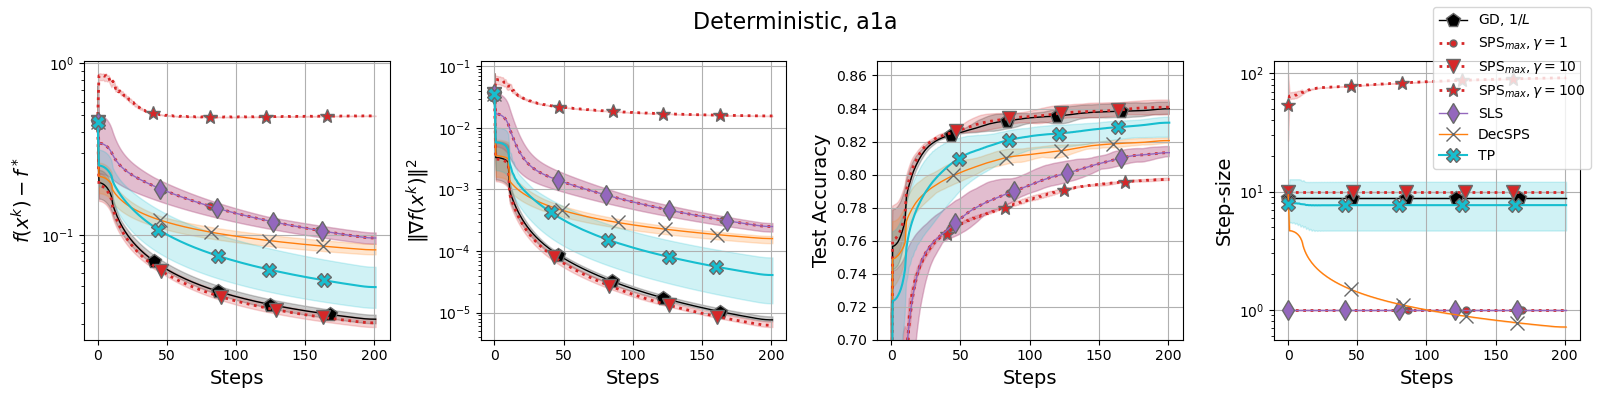

In [248]:
dataset_name = "a1a"
setting = "deterministic"
batch_size=0

n_epochs = 200

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SGD-L",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append(r"GD, $1/L$")
else:
    labels.append(r"SGD, $1/L$")

for eta_max in [1.0, 10.0, 100.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"SPSMAX_{eta_max}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    gamma_b = eta_max
    if eta_max.is_integer():
        gamma_b = round(gamma_b)
    labels.append(r"SPS$_{{max}}, \gamma={0}$".format(gamma_b))
    
seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SLS",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
labels.append(r"SLS")


seed_results = []
eta_max = 10.0
c_0 = 1.0
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
labels.append("DecSPS")

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="STP",
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append("TP")
else:
    labels.append("STP")


with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "tab:red", "tab:red", "tab:red", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", ":", ":", ":", "-", "-", "-"],
        linewidths=[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=10,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Steps", "Steps", "Steps", "Steps"],
        y_labels=[r"$f(x^k) - f^*$", r"$\| \nabla f(x^k) \|^2$", "Test Accuracy", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "train/grad_norm_sq", "test/acc", "lr"],
        y_scales=["log", "log", "linear", "log"],
        mov_ave=[True, True, True, True],
        threshold=0.0,
        acc_ylim=0.7,
        filename=f"{dataset_name}_{setting.lower()}_logreg_4.pdf",
        )

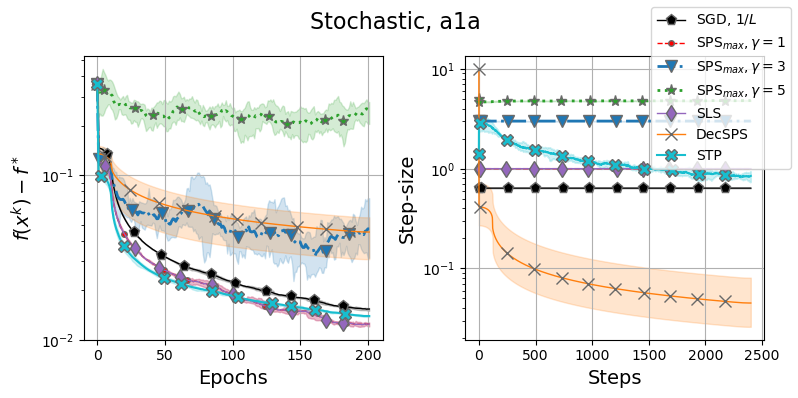

In [306]:
plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Epochs", "Steps"],
        y_labels=[r"$f(x^k) - f^*$", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "lr"],
        y_scales=["log", "log"],
        mov_ave=[True, True],
        threshold=0.0,
        legend_below=False,
        filename=f"{dataset_name}_{setting.lower()}_logreg_2.pdf",
        )

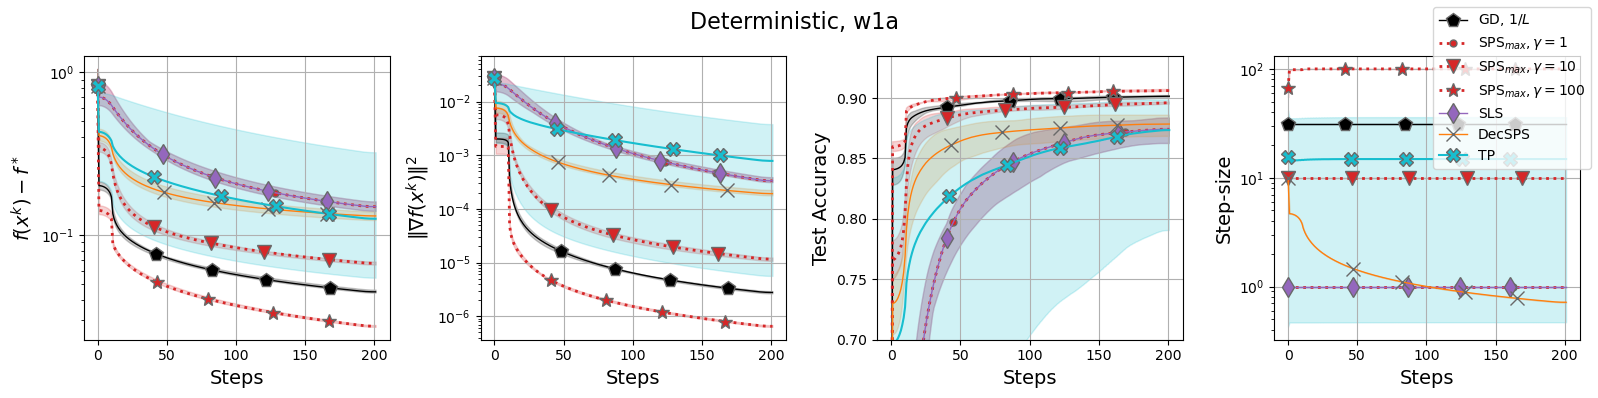

In [249]:
dataset_name = "w1a"
setting = "deterministic"
batch_size=0

n_epochs = 200

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SGD-L",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append(r"GD, $1/L$")
else:
    labels.append(r"SGD, $1/L$")

for eta_max in [1.0, 10.0, 100.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"SPSMAX_{eta_max}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    gamma_b = eta_max
    if eta_max.is_integer():
        gamma_b = round(gamma_b)
    labels.append(r"SPS$_{{max}}, \gamma={0}$".format(gamma_b))
    
seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SLS",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
labels.append(r"SLS")


seed_results = []
eta_max = 10.0
c_0 = 1.0
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
labels.append("DecSPS")

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="STP",
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append("TP")
else:
    labels.append("STP")


with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "tab:red", "tab:red", "tab:red", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", ":", ":", ":", "-", "-", "-"],
        linewidths=[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=10,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Steps", "Steps", "Steps", "Steps"],
        y_labels=[r"$f(x^k) - f^*$", r"$\| \nabla f(x^k) \|^2$", "Test Accuracy", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "train/grad_norm_sq", "test/acc", "lr"],
        y_scales=["log", "log", "linear", "log"],
        mov_ave=[True, True, True, True],
        threshold=0.0,
        acc_ylim=0.7,
        filename=f"{dataset_name}_{setting.lower()}_logreg_4.pdf",
        )

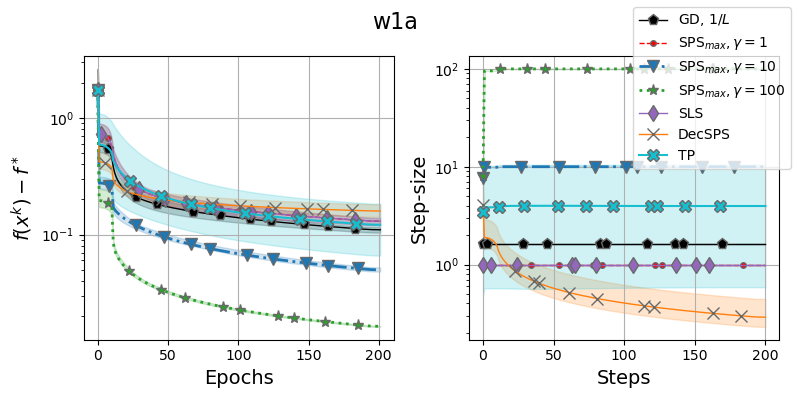

In [308]:
plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Epochs", "Steps"],
        y_labels=[r"$f(x^k) - f^*$", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{dataset_name}",
        metrics=["train/loss", "lr"],
        y_scales=["log", "log"],
        mov_ave=[True, True],
        threshold=0.0,
        legend_below=False,
        filename=f"{dataset_name}_{setting.lower()}_logreg_2.pdf",
        )

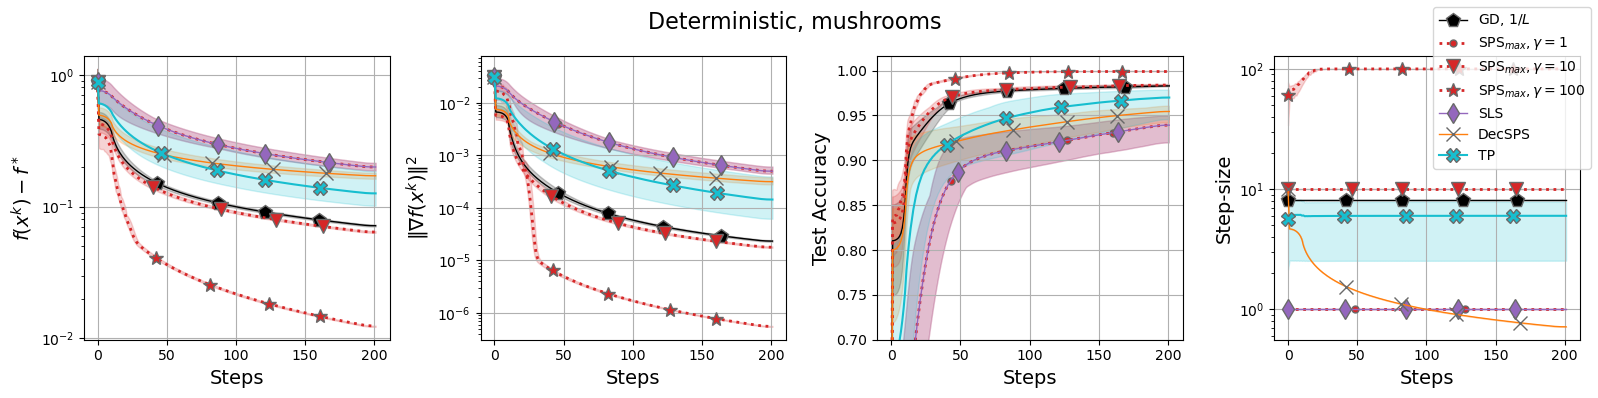

In [250]:
dataset_name = "mushrooms"
setting = "deterministic"
batch_size=0

n_epochs = 200

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SGD-L",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append(r"GD, $1/L$")
else:
    labels.append(r"SGD, $1/L$")

for eta_max in [1.0, 10.0, 100.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"SPSMAX_{eta_max}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    gamma_b = eta_max
    if eta_max.is_integer():
        gamma_b = round(gamma_b)
    labels.append(r"SPS$_{{max}}, \gamma={0}$".format(gamma_b))
    
seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SLS",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
labels.append(r"SLS")


seed_results = []
eta_max = 10.0
c_0 = 1.0
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
labels.append("DecSPS")

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="STP",
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append("TP")
else:
    labels.append("STP")


with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "tab:red", "tab:red", "tab:red", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", ":", ":", ":", "-", "-", "-"],
        linewidths=[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=10,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Steps", "Steps", "Steps", "Steps"],
        y_labels=[r"$f(x^k) - f^*$", r"$\| \nabla f(x^k) \|^2$", "Test Accuracy", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "train/grad_norm_sq", "test/acc", "lr"],
        y_scales=["log", "log", "linear", "log"],
        mov_ave=[True, True, True, True],
        threshold=0.0,
        acc_ylim=0.7,
        filename=f"{dataset_name}_{setting.lower()}_logreg_4.pdf",
        )

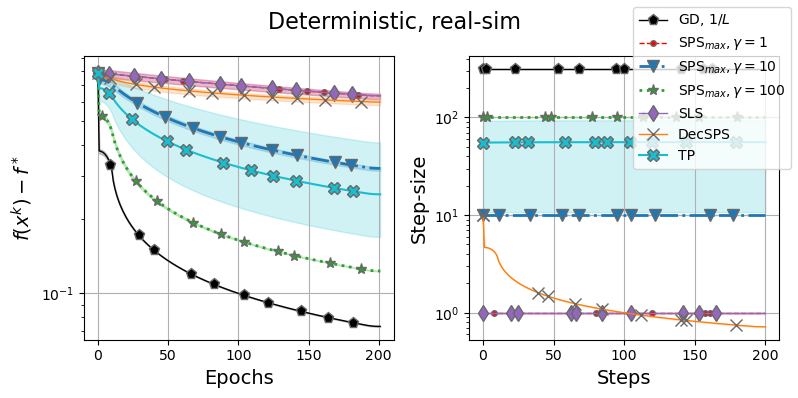

In [313]:
plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Epochs", "Steps"],
        y_labels=[r"$f(x^k) - f^*$", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "lr"],
        y_scales=["log", "log"],
        mov_ave=[True, True],
        threshold=0.0,
        legend_below=False,
        filename=f"{dataset_name}_{setting.lower()}_logreg_2.pdf",
        )

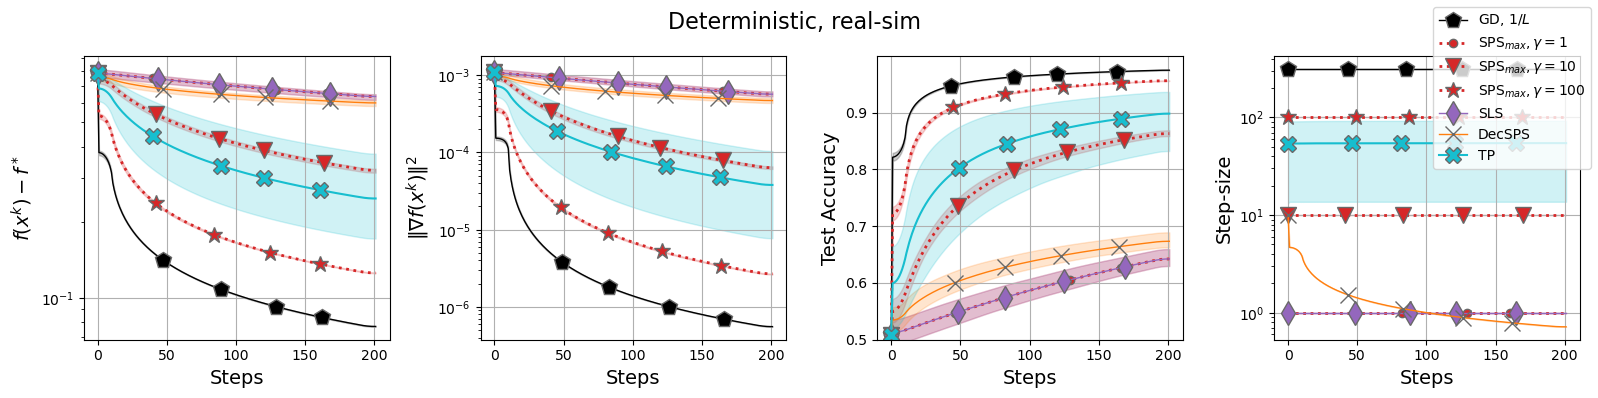

In [251]:
dataset_name = "real-sim"
setting = "deterministic"
batch_size=0

n_epochs = 200

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SGD-L",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append(r"GD, $1/L$")
else:
    labels.append(r"SGD, $1/L$")

for eta_max in [1.0, 10.0, 100.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"SPSMAX_{eta_max}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    gamma_b = eta_max
    if eta_max.is_integer():
        gamma_b = round(gamma_b)
    labels.append(r"SPS$_{{max}}, \gamma={0}$".format(gamma_b))
    
seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SLS",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
labels.append(r"SLS")


seed_results = []
eta_max = 10.0
c_0 = 1.0
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
labels.append("DecSPS")

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="STP",
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append("TP")
else:
    labels.append("STP")


with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "tab:red", "tab:red", "tab:red", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", ":", ":", ":", "-", "-", "-"],
        linewidths=[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=12,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Steps", "Steps", "Steps", "Steps"],
        y_labels=[r"$f(x^k) - f^*$", r"$\| \nabla f(x^k) \|^2$", "Test Accuracy", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "train/grad_norm_sq", "test/acc", "lr"],
        y_scales=["log", "log", "linear", "log"],
        mov_ave=[True, True, True, True],
        threshold=0.0,
        acc_ylim=0.5,
        filename=f"{dataset_name}_{setting.lower()}_logreg_4.pdf",
        )

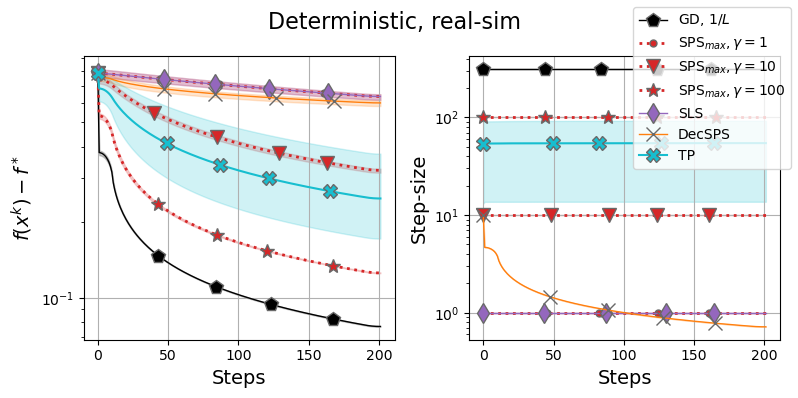

In [224]:
plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "tab:red", "tab:red", "tab:red", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", ":", ":", ":", "-", "-", "-"],
        linewidths=[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=10,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Steps", "Steps"],
        y_labels=[r"$f(x^k) - f^*$", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "lr"],
        y_scales=["log", "log"],
        mov_ave=[True, True],
        threshold=0.0,
        legend_below=False,
        filename=f"{dataset_name}_{setting.lower()}_logreg_2.pdf",
        )

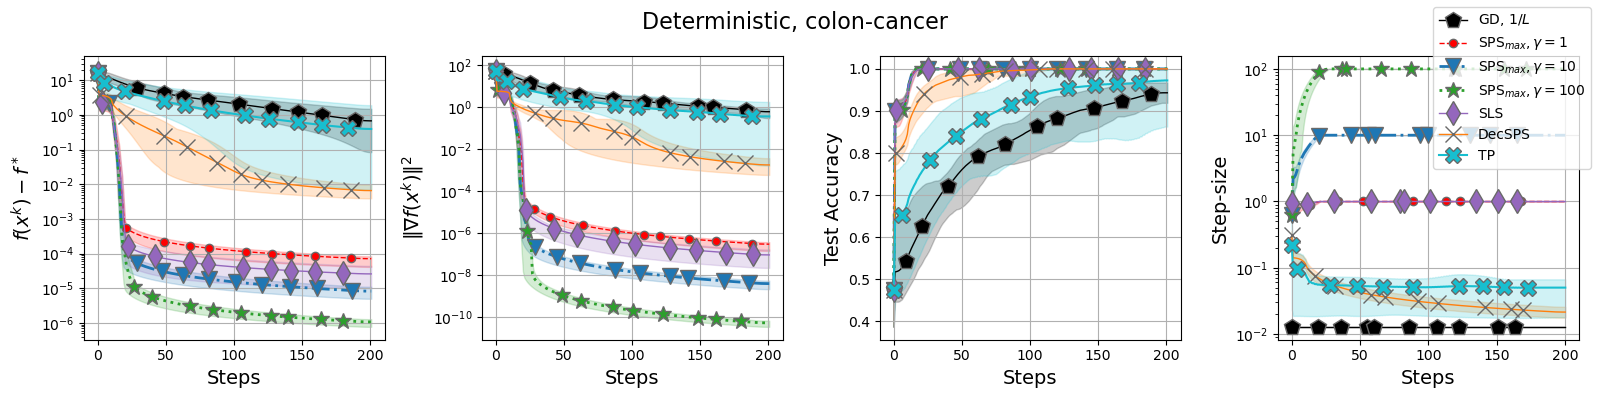

In [320]:
dataset_name = "colon-cancer"
setting = "deterministic"
batch_size=0

n_epochs = 200

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SGD-L",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append(r"GD, $1/L$")
else:
    labels.append(r"SGD, $1/L$")

for eta_max in [1.0, 10.0, 100.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"SPSMAX_{eta_max}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    gamma_b = eta_max
    if eta_max.is_integer():
        gamma_b = round(gamma_b)
    labels.append(r"SPS$_{{max}}, \gamma={0}$".format(gamma_b))
    
seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SLS",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
labels.append(r"SLS")


seed_results = []
eta_max = 10.0
c_0 = 1.0
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
labels.append("DecSPS")

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="STP",
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append("TP")
else:
    labels.append("STP")


with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=12,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=np.asarray(0.0), 
        x_labels=["Steps", "Steps", "Steps", "Steps"],
        y_labels=[r"$f(x^k) - f^*$", r"$\| \nabla f(x^k) \|^2$", "Test Accuracy", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "train/grad_norm_sq", "test/acc", "lr"],
        y_scales=["log", "log", "linear", "log"],
        mov_ave=[True, True, True, True],
        threshold=0.0,
        acc_ylim=None,
        filename=f"{dataset_name}_{setting.lower()}_logreg_4.pdf",
        )

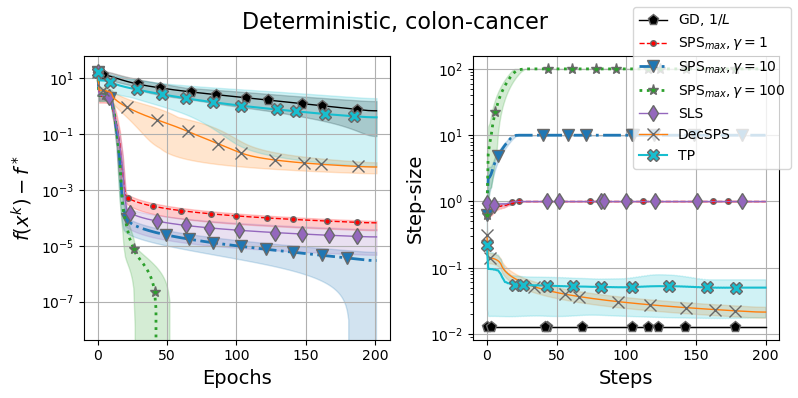

In [321]:
plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=np.asarray(0.0), 
        x_labels=["Epochs", "Steps"],
        y_labels=[r"$f(x^k) - f^*$", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "lr"],
        y_scales=["log", "log"],
        mov_ave=[True, True],
        threshold=0.0,
        legend_below=False,
        filename=f"{dataset_name}_{setting.lower()}_{loss_name}_2.pdf",
        )

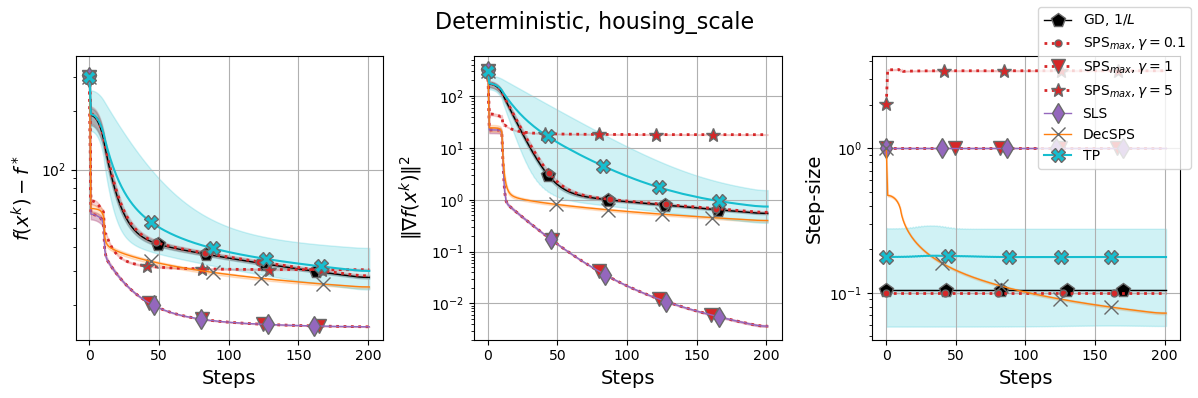

In [252]:
dataset_name = "housing_scale"
setting = "deterministic"
loss_name = "lstsq"
batch_size=0

n_epochs = 200

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SGD-L",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append(r"GD, $1/L$")
else:
    labels.append(r"SGD, $1/L$")

for eta_max in [0.1, 1.0, 5.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss=loss_name, 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"SPSMAX_{eta_max}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    gamma_b = eta_max
    if eta_max.is_integer():
        gamma_b = round(gamma_b)
    labels.append(r"SPS$_{{max}}, \gamma={0}$".format(gamma_b))
    
seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SLS",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
labels.append(r"SLS")


seed_results = []
eta_max = 10.0
c_0 = 1.0
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
labels.append("DecSPS")

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="STP",
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append("TP")
else:
    labels.append("STP")


with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "tab:red", "tab:red", "tab:red", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", ":", ":", ":", "-", "-", "-"],
        linewidths=[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=10,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=np.asarray(0.0), 
        x_labels=["Steps", "Steps", "Steps", "Steps"],
        y_labels=[r"$f(x^k) - f^*$", r"$\| \nabla f(x^k) \|^2$", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "train/grad_norm_sq", "lr"],
        y_scales=["log", "log", "log"],
        mov_ave=[True, True, True, True],
        threshold=0.0,
        acc_ylim=None,
        filename=f"{dataset_name}_{setting.lower()}_{loss_name}_4.pdf",
        )

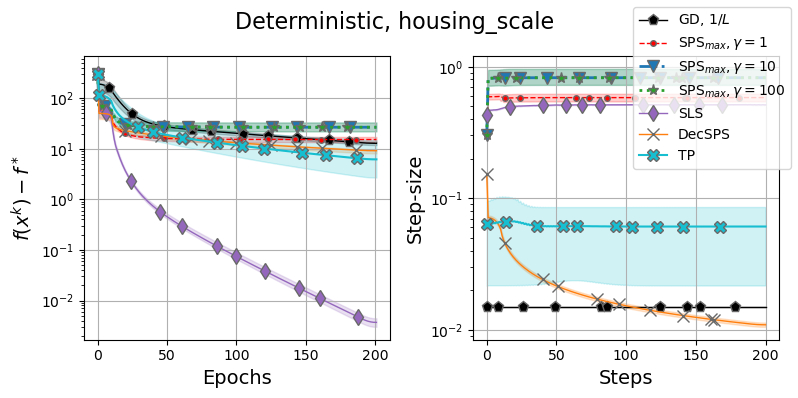

In [317]:
plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Epochs", "Steps"],
        y_labels=[r"$f(x^k) - f^*$", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "lr"],
        y_scales=["log", "log"],
        mov_ave=[True, True],
        threshold=0.0,
        legend_below=False,
        filename=f"{dataset_name}_{setting.lower()}_{loss_name}_2.pdf",
        )

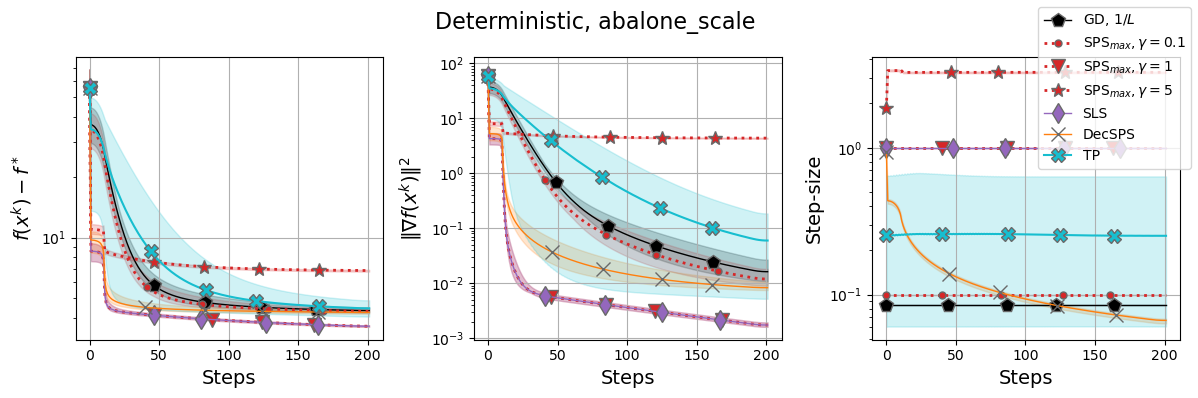

In [253]:
dataset_name = "abalone_scale"
setting = "deterministic"
loss_name = "lstsq"
batch_size=0

n_epochs = 200

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SGD-L",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append(r"GD, $1/L$")
else:
    labels.append(r"SGD, $1/L$")

for eta_max in [0.1, 1.0, 5.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss=loss_name, 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"SPSMAX_{eta_max}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    gamma_b = eta_max
    if eta_max.is_integer():
        gamma_b = round(gamma_b)
    labels.append(r"SPS$_{{max}}, \gamma={0}$".format(gamma_b))
    
seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SLS",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
labels.append(r"SLS")


seed_results = []
eta_max = 10.0
c_0 = 1.0
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
labels.append("DecSPS")

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="STP",
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append("TP")
else:
    labels.append("STP")


with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "tab:red", "tab:red", "tab:red", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", ":", ":", ":", "-", "-", "-"],
        linewidths=[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=10,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=np.asarray(0.0), 
        x_labels=["Steps", "Steps", "Steps", "Steps"],
        y_labels=[r"$f(x^k) - f^*$", r"$\| \nabla f(x^k) \|^2$", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "train/grad_norm_sq", "lr"],
        y_scales=["log", "log", "log"],
        mov_ave=[True, True, True, True],
        threshold=0.0,
        acc_ylim=None,
        filename=f"{dataset_name}_{setting.lower()}_{loss_name}_4.pdf",
        )

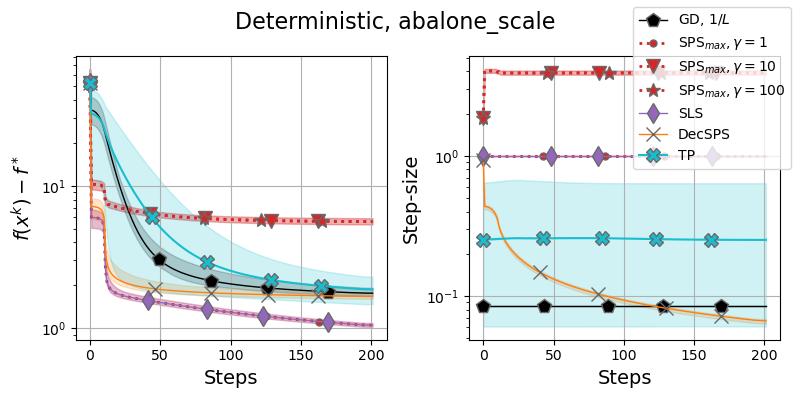

In [222]:
plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "tab:red", "tab:red", "tab:red", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", ":", ":", ":", "-", "-", "-"],
        linewidths=[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=10,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Steps", "Steps"],
        y_labels=[r"$f(x^k) - f^*$", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "lr"],
        y_scales=["log", "log"],
        mov_ave=[True, True],
        threshold=0.0,
        legend_below=False,
        filename=f"{dataset_name}_{setting.lower()}_{loss_name}_2.pdf",
        )

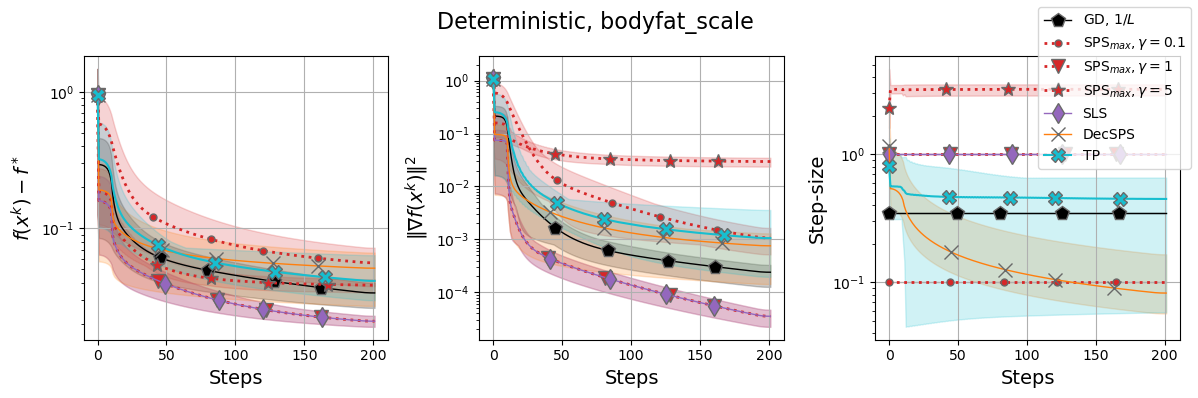

In [254]:
dataset_name = "bodyfat_scale"
setting = "deterministic"
loss_name = "lstsq"
batch_size=0

n_epochs = 200

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SGD-L",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append(r"GD, $1/L$")
else:
    labels.append(r"SGD, $1/L$")

for eta_max in [0.1, 1.0, 5.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss=loss_name, 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"SPSMAX_{eta_max}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    gamma_b = eta_max
    if eta_max.is_integer():
        gamma_b = round(gamma_b)
    labels.append(r"SPS$_{{max}}, \gamma={0}$".format(gamma_b))
    
seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SLS",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
labels.append(r"SLS")


seed_results = []
eta_max = 10.0
c_0 = 1.0
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
labels.append("DecSPS")

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="STP",
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append("TP")
else:
    labels.append("STP")


with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "tab:red", "tab:red", "tab:red", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", ":", ":", ":", "-", "-", "-"],
        linewidths=[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=10,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=np.asarray(0.0), 
        x_labels=["Steps", "Steps", "Steps", "Steps"],
        y_labels=[r"$f(x^k) - f^*$", r"$\| \nabla f(x^k) \|^2$", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "train/grad_norm_sq", "lr"],
        y_scales=["log", "log", "log"],
        mov_ave=[True, True, True, True],
        threshold=0.0,
        acc_ylim=None,
        filename=f"{dataset_name}_{setting.lower()}_{loss_name}_4.pdf",
        )

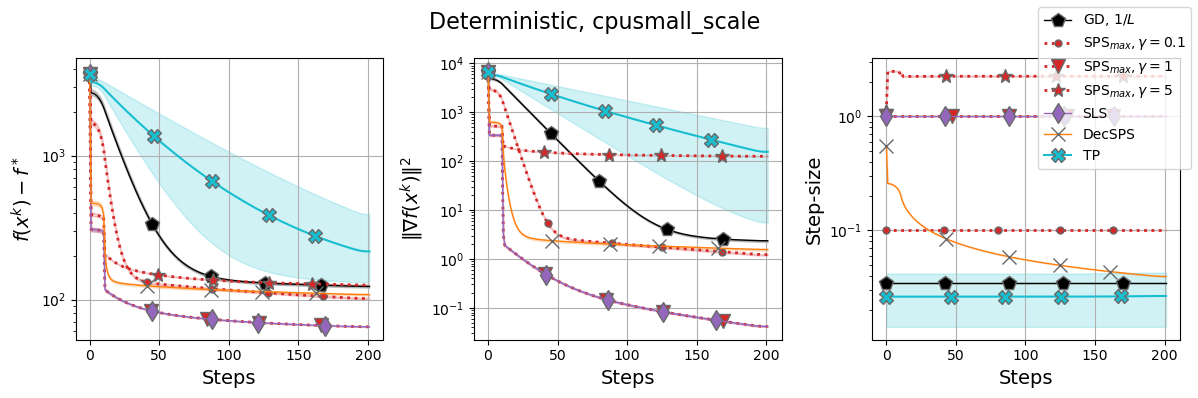

In [255]:
dataset_name = "cpusmall_scale"
setting = "deterministic"
loss_name = "lstsq"
batch_size=0

n_epochs = 200

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SGD-L",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append(r"GD, $1/L$")
else:
    labels.append(r"SGD, $1/L$")

for eta_max in [0.1, 1.0, 5.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss=loss_name, 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"SPSMAX_{eta_max}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    gamma_b = eta_max
    if eta_max.is_integer():
        gamma_b = round(gamma_b)
    labels.append(r"SPS$_{{max}}, \gamma={0}$".format(gamma_b))
    
seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SLS",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
labels.append(r"SLS")


seed_results = []
eta_max = 10.0
c_0 = 1.0
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
labels.append("DecSPS")

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="STP",
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append("TP")
else:
    labels.append("STP")


with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "tab:red", "tab:red", "tab:red", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", ":", ":", ":", "-", "-", "-"],
        linewidths=[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=10,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=np.asarray(0.0), 
        x_labels=["Steps", "Steps", "Steps", "Steps"],
        y_labels=[r"$f(x^k) - f^*$", r"$\| \nabla f(x^k) \|^2$", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "train/grad_norm_sq", "lr"],
        y_scales=["log", "log", "log"],
        mov_ave=[True, True, True, True],
        threshold=0.0,
        acc_ylim=None,
        filename=f"{dataset_name}_{setting.lower()}_{loss_name}_4.pdf",
        )

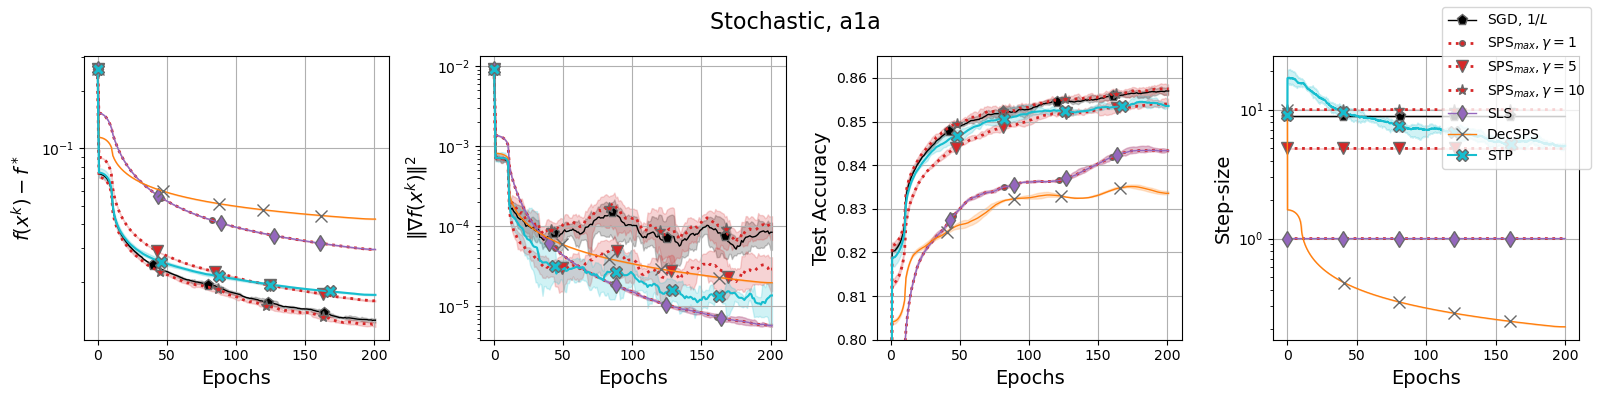

In [229]:
dataset_name = "a1a"
setting = "stochastic"
batch_size=128

n_epochs = 200

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SGD-L",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append(r"GD, $1/L$")
else:
    labels.append(r"SGD, $1/L$")

for eta_max in [1.0, 5.0, 10.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"SPSMAX_{eta_max}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    gamma_b = eta_max
    if eta_max.is_integer():
        gamma_b = round(gamma_b)
    labels.append(r"SPS$_{{max}}, \gamma={0}$".format(gamma_b))
    
seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SLS",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
labels.append(r"SLS")


seed_results = []
eta_max = 10.0
c_0 = 1.0
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
labels.append("DecSPS")

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="STP",
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append("TP")
else:
    labels.append("STP")


with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "tab:red", "tab:red", "tab:red", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", ":", ":", ":", "-", "-", "-"],
        linewidths=[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Epochs", "Epochs", "Epochs", "Epochs"],
        y_labels=[r"$f(x^k) - f^*$", r"$\| \nabla f(x^k) \|^2$", "Test Accuracy", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "train/grad_norm_sq", "test/acc", "lr"],
        y_scales=["log", "log", "linear", "log"],
        mov_ave=[True, True, True, True],
        threshold=0.0,
        acc_ylim=0.8,
        filename=f"{dataset_name}_{setting.lower()}_logreg_4.pdf",
        )

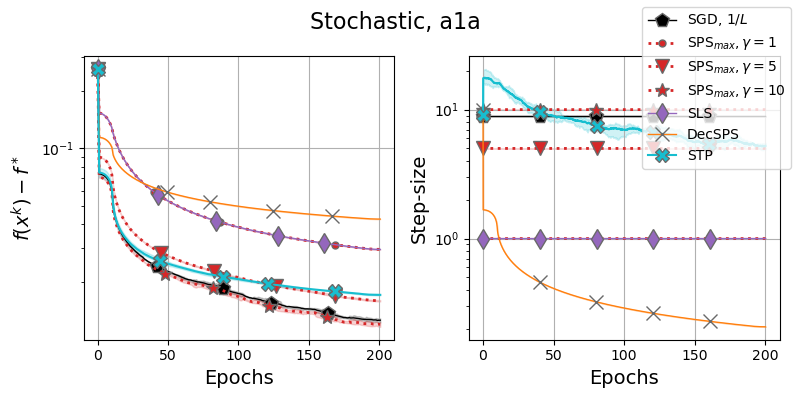

In [230]:
plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "tab:red", "tab:red", "tab:red", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", ":", ":", ":", "-", "-", "-"],
        linewidths=[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=10,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Epochs", "Epochs"],
        y_labels=[r"$f(x^k) - f^*$", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "lr"],
        y_scales=["log", "log"],
        mov_ave=[True, True],
        threshold=0.0,
        legend_below=False,
        filename=f"{dataset_name}_{setting.lower()}_logreg_2.pdf",
        )

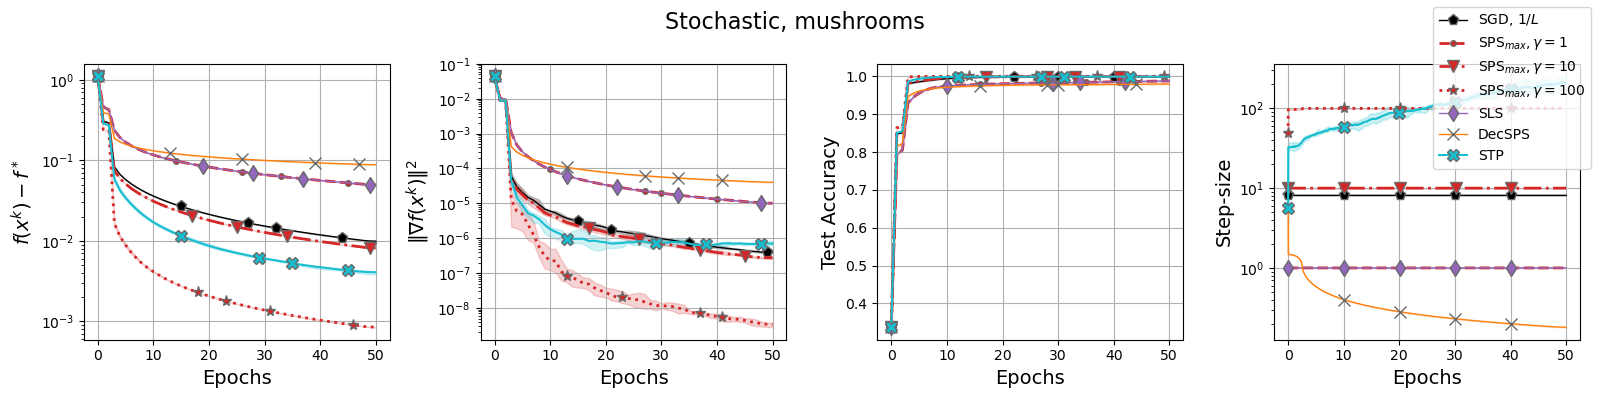

In [231]:
dataset_name = "mushrooms"
setting = "stochastic"
batch_size=128

n_epochs = 50

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SGD-L",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append(r"GD, $1/L$")
else:
    labels.append(r"SGD, $1/L$")

for eta_max in [1.0, 10.0, 100.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"SPSMAX_{eta_max}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    gamma_b = eta_max
    if eta_max.is_integer():
        gamma_b = round(gamma_b)
    labels.append(r"SPS$_{{max}}, \gamma={0}$".format(gamma_b))
    
seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SLS",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
labels.append(r"SLS")


seed_results = []
eta_max = 10.0
c_0 = 1.0
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
labels.append("DecSPS")

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="STP",
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append("TP")
else:
    labels.append("STP")


with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "tab:red", "tab:red", "tab:red", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Epochs", "Epochs", "Epochs", "Epochs"],
        y_labels=[r"$f(x^k) - f^*$", r"$\| \nabla f(x^k) \|^2$", "Test Accuracy", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "train/grad_norm_sq", "test/acc", "lr"],
        y_scales=["log", "log", "linear", "log"],
        mov_ave=[True, True, True, True],
        threshold=0.0,
        acc_ylim=None,
        filename=f"{dataset_name}_{setting.lower()}_logreg_4.pdf",
        )

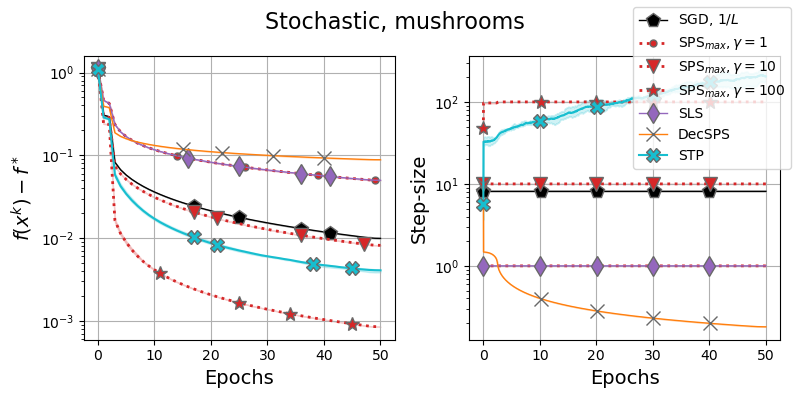

In [232]:
plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "tab:red", "tab:red", "tab:red", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", ":", ":", ":", "-", "-", "-"],
        linewidths=[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=10,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Epochs", "Epochs"],
        y_labels=[r"$f(x^k) - f^*$", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "lr"],
        y_scales=["log", "log"],
        mov_ave=[True, True],
        threshold=0.0,
        legend_below=False,
        filename=f"{dataset_name}_{setting.lower()}_logreg_2.pdf",
        )

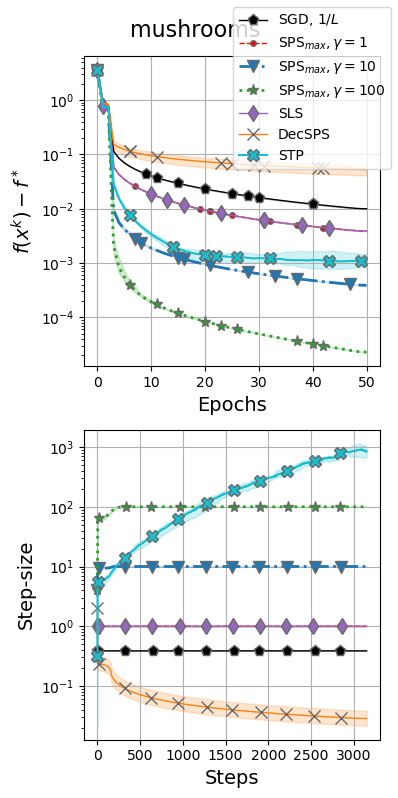

In [299]:
plotter_seeds_r(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Epochs", "Steps"],
        y_labels=[r"$f(x^k) - f^*$", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{dataset_name}",
        metrics=["train/loss", "lr"],
        y_scales=["log", "log"],
        mov_ave=[True, True],
        threshold=0.0,
        legend_below=False,
        filename=f"{dataset_name}_{setting.lower()}_logreg_2_rotated.pdf",
        )

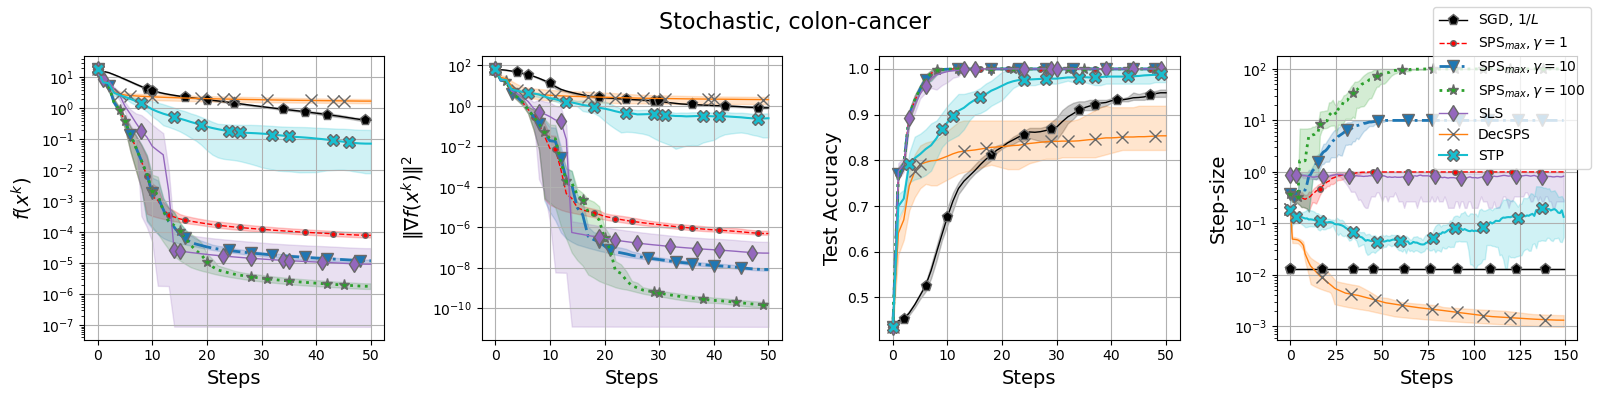

In [161]:
dataset_name = "colon-cancer"
setting = "stochastic"
batch_size=16

n_epochs = 50

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SGD-L",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append(r"GD, $1/L$")
else:
    labels.append(r"SGD, $1/L$")

for eta_max in [1.0, 10.0, 100.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"SPSMAX_{eta_max}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    gamma_b = eta_max
    if eta_max.is_integer():
        gamma_b = round(gamma_b)
    labels.append(r"SPS$_{{max}}, \gamma={0}$".format(gamma_b))
    
seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SLS",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
labels.append(r"SLS")


seed_results = []
eta_max = 10.0
c_0 = 1.0
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
labels.append("DecSPS")

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="STP",
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append("TP")
else:
    labels.append("STP")


with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=np.asarray(0.0), 
        x_labels=["Steps", "Steps", "Steps", "Steps"],
        y_labels=[r"$f(x^k)$", r"$\| \nabla f(x^k) \|^2$", "Test Accuracy", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "train/grad_norm_sq", "test/acc", "lr"],
        y_scales=["log", "log", "linear", "log"],
        mov_ave=[True, True, True, True],
        threshold=0.0,
        acc_ylim=None,
        filename=f"{dataset_name}_{setting.lower()}_logreg_4.pdf",
        )

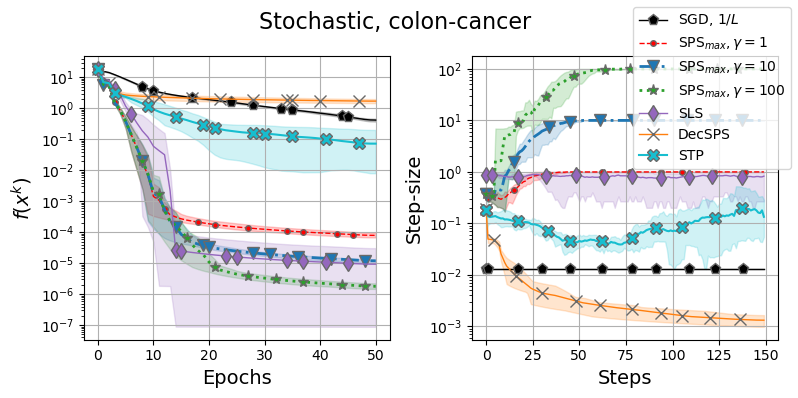

In [162]:
plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=np.asarray(0.0), 
        x_labels=["Epochs", "Steps"],
        y_labels=[r"$f(x^k)$", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "lr"],
        y_scales=["log", "log"],
        mov_ave=[True, True],
        threshold=0.0,
        legend_below=False,
        filename=f"{dataset_name}_{setting.lower()}_logreg_2.pdf",
        )

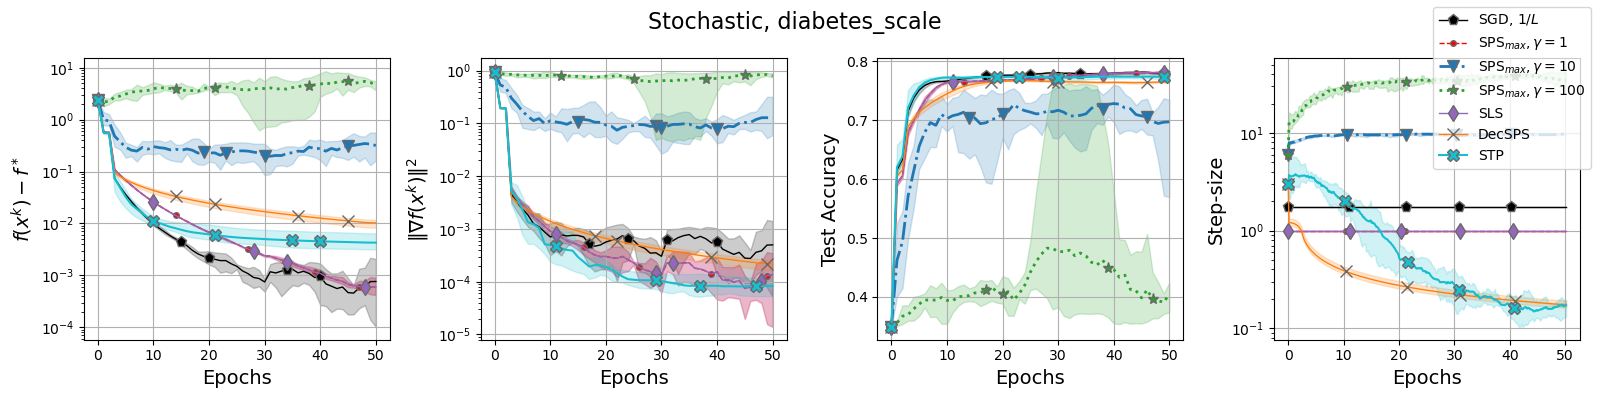

In [126]:
dataset_name = "diabetes_scale"
setting = "stochastic"
batch_size=128

n_epochs = 50

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SGD-L",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append(r"GD, $1/L$")
else:
    labels.append(r"SGD, $1/L$")

for eta_max in [1.0, 10.0, 100.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"SPSMAX_{eta_max}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    gamma_b = eta_max
    if eta_max.is_integer():
        gamma_b = round(gamma_b)
    labels.append(r"SPS$_{{max}}, \gamma={0}$".format(gamma_b))
    
seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SLS",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
labels.append(r"SLS")


seed_results = []
eta_max = 10.0
c_0 = 1.0
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
labels.append("DecSPS")

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="STP",
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append("TP")
else:
    labels.append("STP")


with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Epochs", "Epochs", "Epochs", "Epochs"],
        y_labels=[r"$f(x^k) - f^*$", r"$\| \nabla f(x^k) \|^2$", "Test Accuracy", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "train/grad_norm_sq", "test/acc", "lr"],
        y_scales=["log", "log", "linear", "log"],
        mov_ave=[True, True, True, True],
        threshold=0.0,
        acc_ylim=None,
        filename=f"{dataset_name}_{setting.lower()}_logreg_4.pdf",
        )

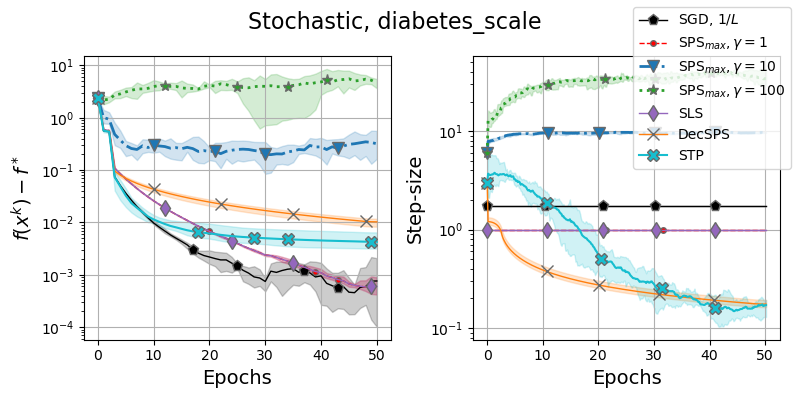

In [127]:
plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Epochs", "Epochs"],
        y_labels=[r"$f(x^k) - f^*$", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "lr"],
        y_scales=["log", "log"],
        mov_ave=[True, True],
        threshold=0.0,
        legend_below=False,
        filename=f"{dataset_name}_{setting.lower()}_logreg_2.pdf",
        )

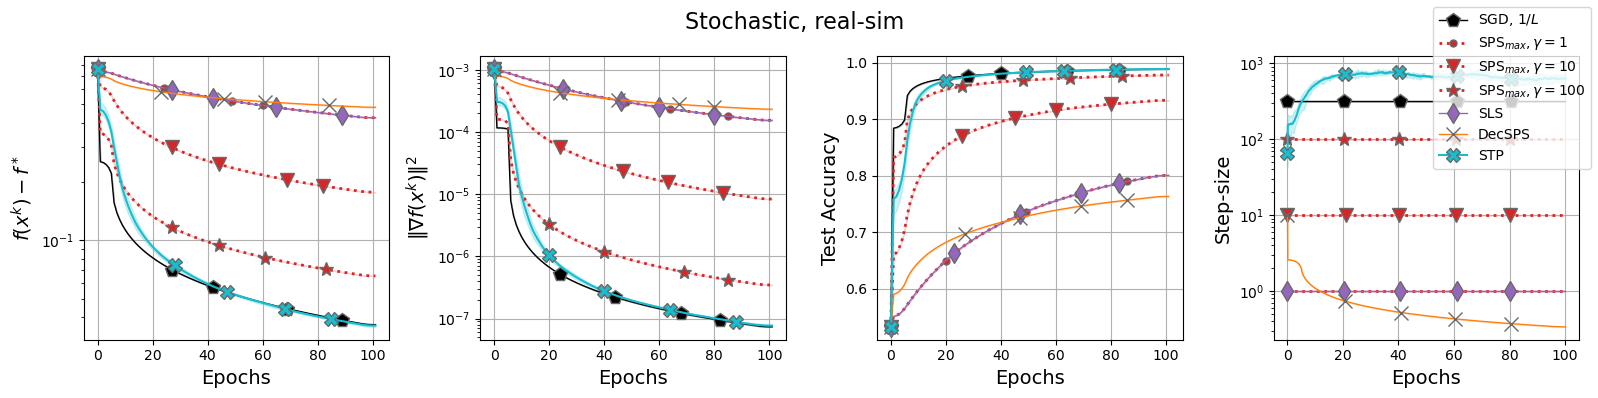

In [233]:
dataset_name = "real-sim"
setting = "stochastic"
batch_size=8000

n_epochs = 100

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SGD-L",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append(r"GD, $1/L$")
else:
    labels.append(r"SGD, $1/L$")

for eta_max in [1.0, 10.0, 100.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"SPSMAX_{eta_max}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    gamma_b = eta_max
    if eta_max.is_integer():
        gamma_b = round(gamma_b)
    labels.append(r"SPS$_{{max}}, \gamma={0}$".format(gamma_b))
    
seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SLS",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
labels.append(r"SLS")


seed_results = []
eta_max = 10.0
c_0 = 1.0
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
labels.append("DecSPS")

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="STP",
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append("TP")
else:
    labels.append("STP")

with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "tab:red", "tab:red", "tab:red", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", ":", ":", ":", "-", "-", "-"],
        linewidths=[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=10,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Epochs", "Epochs", "Epochs", "Epochs"],
        y_labels=[r"$f(x^k) - f^*$", r"$\| \nabla f(x^k) \|^2$", "Test Accuracy", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "train/grad_norm_sq", "test/acc", "lr"],
        y_scales=["log", "log", "linear", "log"],
        mov_ave=[True, True, True, True],
        threshold=0.0,
        acc_ylim=None,
        filename=f"{dataset_name}_{setting.lower()}_logreg_4.pdf",
        )

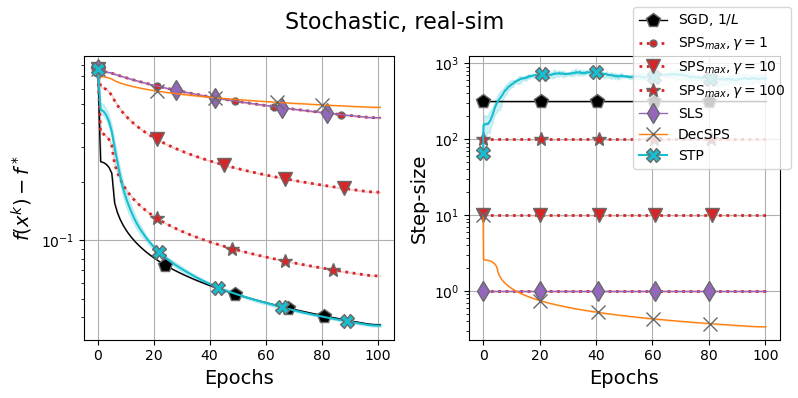

In [234]:
plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "tab:red", "tab:red", "tab:red", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", ":", ":", ":", "-", "-", "-"],
        linewidths=[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=10,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Epochs", "Epochs"],
        y_labels=[r"$f(x^k) - f^*$", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "lr"],
        y_scales=["log", "log"],
        mov_ave=[True, True],
        threshold=0.0,
        legend_below=False,
        filename=f"{dataset_name}_{setting.lower()}_logreg_2.pdf",
        )

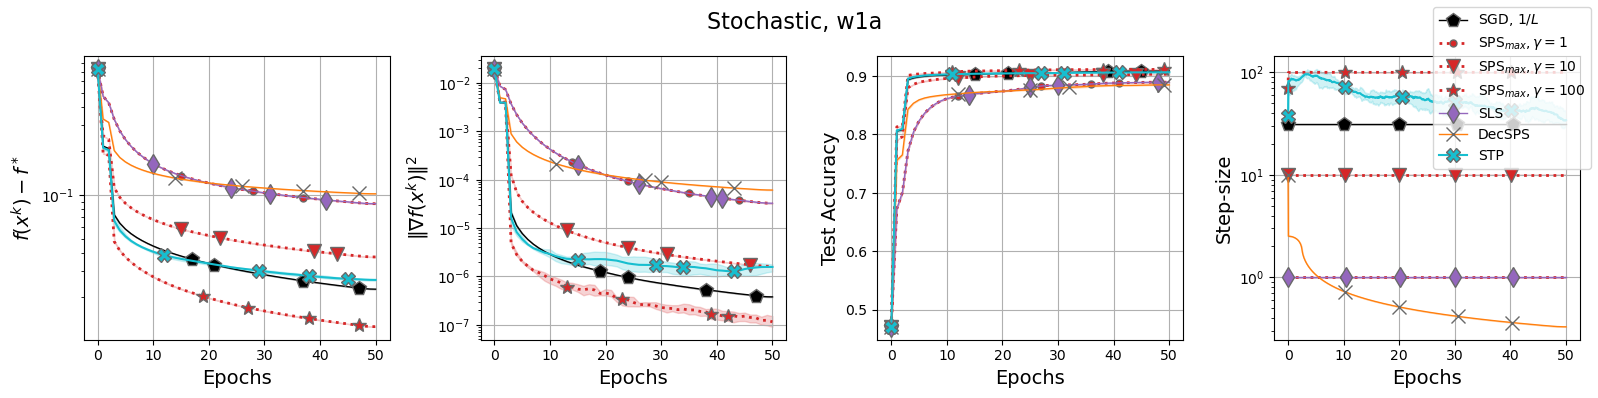

In [236]:
dataset_name = "w1a"
setting = "stochastic"
batch_size=128

n_epochs = 50

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SGD-L",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append(r"GD, $1/L$")
else:
    labels.append(r"SGD, $1/L$")

for eta_max in [1.0, 10.0, 100.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"SPSMAX_{eta_max}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    gamma_b = eta_max
    if eta_max.is_integer():
        gamma_b = round(gamma_b)
    labels.append(r"SPS$_{{max}}, \gamma={0}$".format(gamma_b))
    
seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SLS",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
labels.append(r"SLS")


seed_results = []
eta_max = 10.0
c_0 = 1.0
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
labels.append("DecSPS")

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="STP",
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append("TP")
else:
    labels.append("STP")


with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "tab:red", "tab:red", "tab:red", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", ":", ":", ":", "-", "-", "-"],
        linewidths=[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=10,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Epochs", "Epochs", "Epochs", "Epochs"],
        y_labels=[r"$f(x^k) - f^*$", r"$\| \nabla f(x^k) \|^2$", "Test Accuracy", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "train/grad_norm_sq", "test/acc", "lr"],
        y_scales=["log", "log", "linear", "log"],
        mov_ave=[True, True, True, True],
        threshold=0.0,
        acc_ylim=None,
        filename=f"{dataset_name}_{setting.lower()}_logreg_4.pdf",
        )

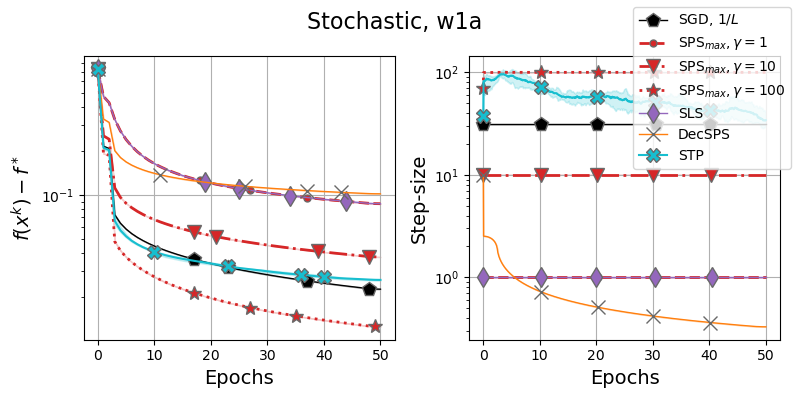

In [237]:
plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "tab:red", "tab:red", "tab:red", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=10,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Epochs", "Epochs"],
        y_labels=[r"$f(x^k) - f^*$", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "lr"],
        y_scales=["log", "log"],
        mov_ave=[True, True],
        threshold=0.0,
        legend_below=False,
        filename=f"{dataset_name}_{setting.lower()}_logreg_2.pdf",
        )

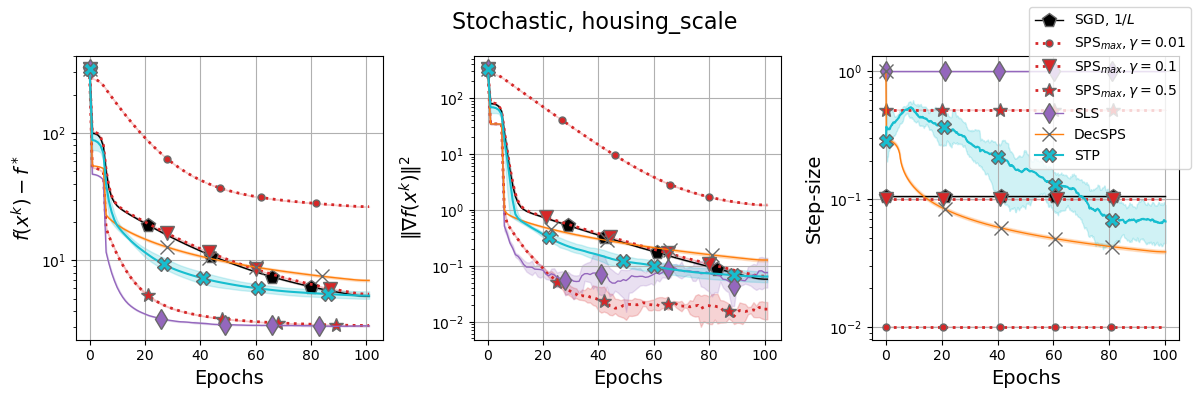

In [238]:
dataset_name = "housing_scale"
setting = "stochastic"
loss_name = "lstsq"
batch_size=64

n_epochs = 100

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SGD-L",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append(r"GD, $1/L$")
else:
    labels.append(r"SGD, $1/L$")

for eta_max in [0.01, 0.1, 0.5]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss=loss_name, 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"SPSMAX_{eta_max}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    gamma_b = eta_max
    if eta_max.is_integer():
        gamma_b = round(gamma_b)
    labels.append(r"SPS$_{{max}}, \gamma={0}$".format(gamma_b))
    
seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SLS",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
labels.append(r"SLS")


seed_results = []
eta_max = 10.0
c_0 = 1.0
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
labels.append("DecSPS")

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="STP",
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append("TP")
else:
    labels.append("STP")


with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "tab:red", "tab:red", "tab:red", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", ":", ":", ":", "-", "-", "-"],
        linewidths=[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=10,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Epochs", "Epochs", "Epochs", "Epochs"],
        y_labels=[r"$f(x^k) - f^*$", r"$\| \nabla f(x^k) \|^2$", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "train/grad_norm_sq", "lr"],
        y_scales=["log", "log", "log"],
        mov_ave=[True, True, True, True],
        threshold=0.0,
        acc_ylim=None,
        filename=f"{dataset_name}_{setting.lower()}_{loss_name}_4.pdf",
        )

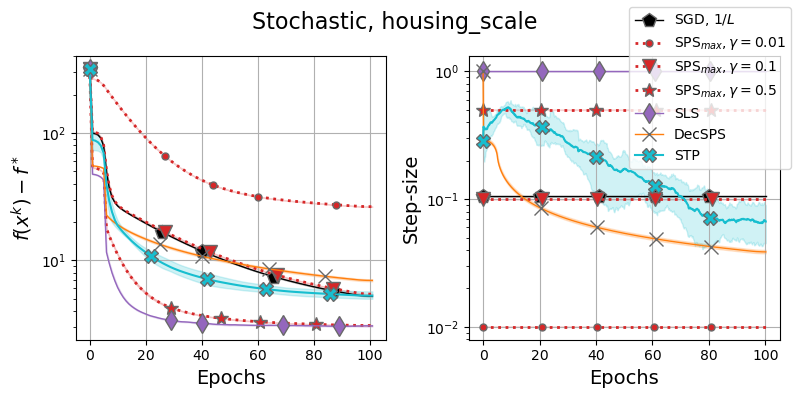

In [239]:
plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "tab:red", "tab:red", "tab:red", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", ":", ":", ":", "-", "-", "-"],
        linewidths=[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=10,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Epochs", "Epochs"],
        y_labels=[r"$f(x^k) - f^*$", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "lr"],
        y_scales=["log", "log"],
        mov_ave=[True, True],
        threshold=0.0,
        legend_below=False,
        filename=f"{dataset_name}_{setting.lower()}_{loss_name}_2.pdf",
        )

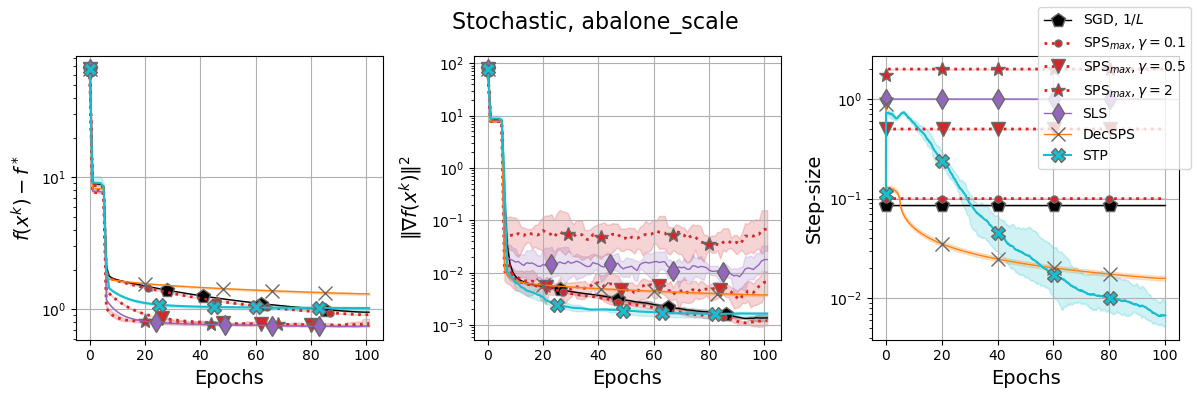

In [241]:
dataset_name = "abalone_scale"
setting = "stochastic"
loss_name = "lstsq"
batch_size=128

n_epochs = 100

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SGD-L",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append(r"GD, $1/L$")
else:
    labels.append(r"SGD, $1/L$")

for eta_max in [0.1, 0.5, 2.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss=loss_name, 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"SPSMAX_{eta_max}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    gamma_b = eta_max
    if eta_max.is_integer():
        gamma_b = round(gamma_b)
    labels.append(r"SPS$_{{max}}, \gamma={0}$".format(gamma_b))
    
seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SLS",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
labels.append(r"SLS")


seed_results = []
eta_max = 10.0
c_0 = 1.0
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
labels.append("DecSPS")

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="STP",
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append("TP")
else:
    labels.append("STP")


with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "tab:red", "tab:red", "tab:red", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", ":", ":", ":", "-", "-", "-"],
        linewidths=[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=10,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Epochs", "Epochs", "Epochs", "Epochs"],
        y_labels=[r"$f(x^k) - f^*$", r"$\| \nabla f(x^k) \|^2$", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "train/grad_norm_sq", "lr"],
        y_scales=["log", "log", "log"],
        mov_ave=[True, True, True, True],
        threshold=0.0,
        acc_ylim=None,
        filename=f"{dataset_name}_{setting.lower()}_{loss_name}_4.pdf",
        )

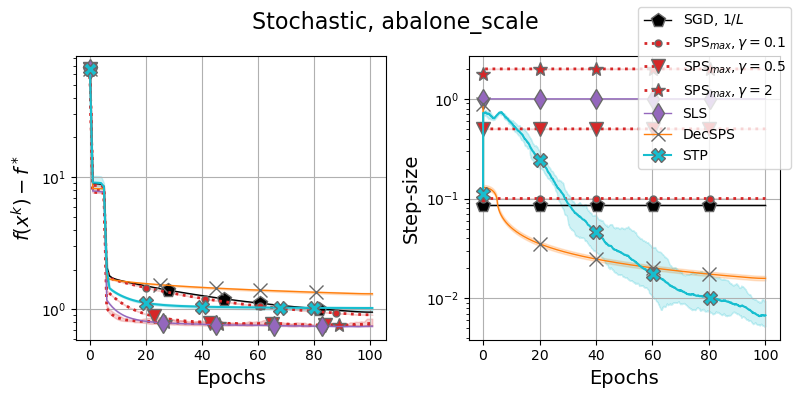

In [242]:
plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "tab:red", "tab:red", "tab:red", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", ":", ":", ":", "-", "-", "-"],
        linewidths=[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=10,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Epochs", "Epochs"],
        y_labels=[r"$f(x^k) - f^*$", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "lr"],
        y_scales=["log", "log"],
        mov_ave=[True, True],
        threshold=0.0,
        legend_below=False,
        filename=f"{dataset_name}_{setting.lower()}_{loss_name}_2.pdf",
        )

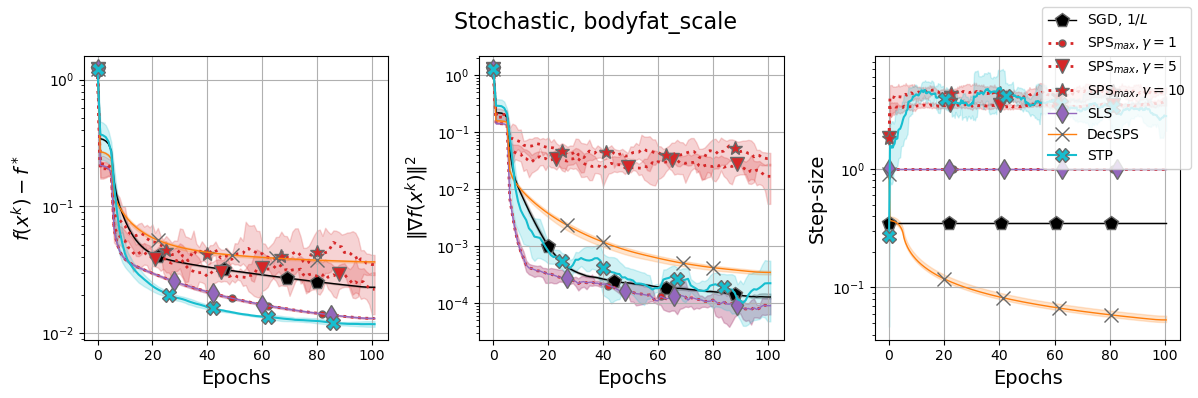

In [243]:
dataset_name = "bodyfat_scale"
setting = "stochastic"
loss_name = "lstsq"
batch_size=64

n_epochs = 100

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SGD-L",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append(r"GD, $1/L$")
else:
    labels.append(r"SGD, $1/L$")

for eta_max in [1.0, 5.0, 10.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss=loss_name, 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"SPSMAX_{eta_max}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    gamma_b = eta_max
    if eta_max.is_integer():
        gamma_b = round(gamma_b)
    labels.append(r"SPS$_{{max}}, \gamma={0}$".format(gamma_b))
    
seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SLS",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
labels.append(r"SLS")


seed_results = []
eta_max = 10.0
c_0 = 1.0
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
labels.append("DecSPS")

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="STP",
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append("TP")
else:
    labels.append("STP")


with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "tab:red", "tab:red", "tab:red", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", ":", ":", ":", "-", "-", "-"],
        linewidths=[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=10,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Epochs", "Epochs", "Epochs", "Epochs"],
        y_labels=[r"$f(x^k) - f^*$", r"$\| \nabla f(x^k) \|^2$", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "train/grad_norm_sq", "lr"],
        y_scales=["log", "log", "log"],
        mov_ave=[True, True, True, True],
        threshold=0.0,
        acc_ylim=None,
        filename=f"{dataset_name}_{setting.lower()}_{loss_name}_4.pdf",
        )

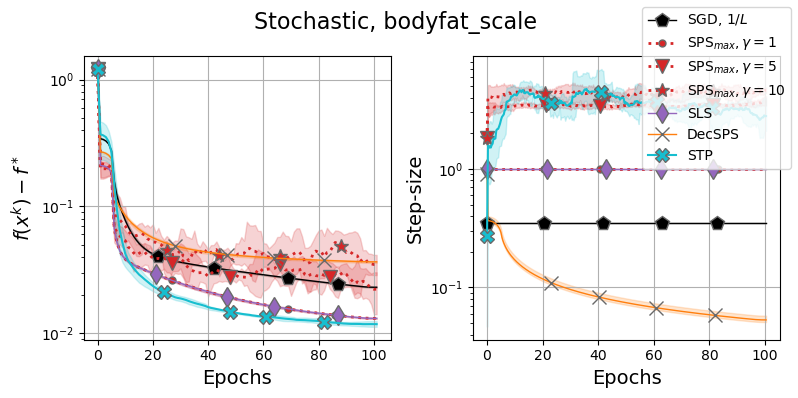

In [244]:
plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "tab:red", "tab:red", "tab:red", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", ":", ":", ":", "-", "-", "-"],
        linewidths=[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=10,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Epochs", "Epochs"],
        y_labels=[r"$f(x^k) - f^*$", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "lr"],
        y_scales=["log", "log"],
        mov_ave=[True, True],
        threshold=0.0,
        legend_below=False,
        filename=f"{dataset_name}_{setting.lower()}_{loss_name}_2.pdf",
        )

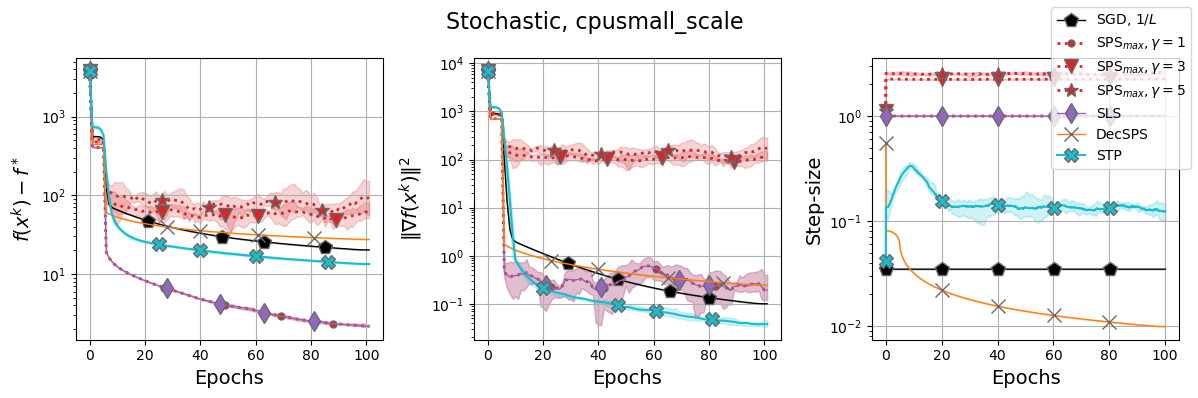

In [246]:
dataset_name = "cpusmall_scale"
setting = "stochastic"
loss_name = "lstsq"
batch_size=256

n_epochs = 100

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SGD-L",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append(r"GD, $1/L$")
else:
    labels.append(r"SGD, $1/L$")

for eta_max in [1.0, 3.0, 5.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss=loss_name, 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"SPSMAX_{eta_max}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    gamma_b = eta_max
    if eta_max.is_integer():
        gamma_b = round(gamma_b)
    labels.append(r"SPS$_{{max}}, \gamma={0}$".format(gamma_b))
    
seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SLS",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
labels.append(r"SLS")


seed_results = []
eta_max = 10.0
c_0 = 1.0
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
labels.append("DecSPS")

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="STP",
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append("TP")
else:
    labels.append("STP")


with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "tab:red", "tab:red", "tab:red", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", ":", ":", ":", "-", "-", "-"],
        linewidths=[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=10,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Epochs", "Epochs", "Epochs", "Epochs"],
        y_labels=[r"$f(x^k) - f^*$", r"$\| \nabla f(x^k) \|^2$", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "train/grad_norm_sq", "lr"],
        y_scales=["log", "log", "log"],
        mov_ave=[True, True, True, True],
        threshold=0.0,
        acc_ylim=None,
        filename=f"{dataset_name}_{setting.lower()}_{loss_name}_4.pdf",
        )

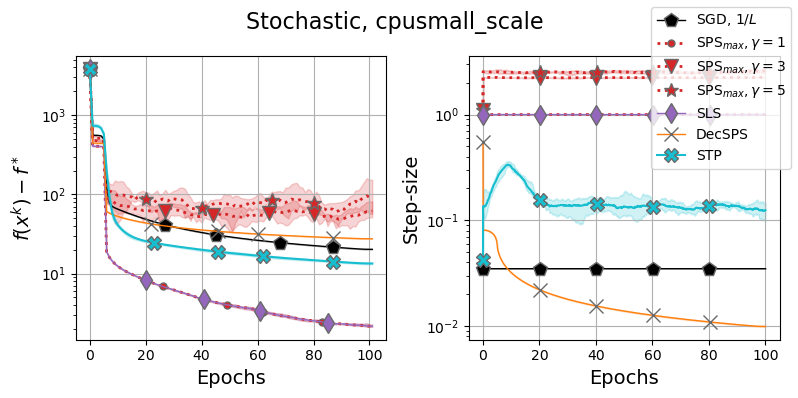

In [247]:
plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "tab:red", "tab:red", "tab:red", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", ":", ":", ":", "-", "-", "-"],
        linewidths=[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=10,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Epochs", "Epochs"],
        y_labels=[r"$f(x^k) - f^*$", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "lr"],
        y_scales=["log", "log"],
        mov_ave=[True, True],
        threshold=0.0,
        legend_below=False,
        filename=f"{dataset_name}_{setting.lower()}_{loss_name}_2.pdf",
        )

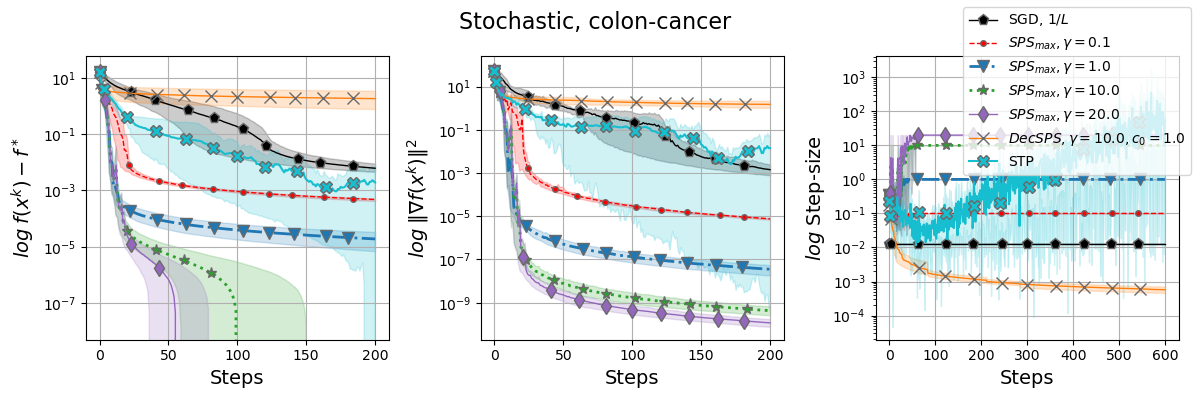

In [ ]:
setting = "stochastic"
batch_size = 16
dataset_name = "colon-cancer"

n_epochs = 200

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SGD-L",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append(r"GD, $1/L$")
else:
    labels.append(r"SGD, $1/L$")

for eta_max in [0.1, 1.0, 10.0, 20.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"SPSMAX_{eta_max}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    labels.append(r"$SPS_{{max}}, \gamma={0}$".format(eta_max))

seed_results = []
eta_max = 10.0
c_0 = 1.0
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
labels.append(r"$DecSPS, \gamma={0}, c_0={1}$".format(eta_max, c_0))

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="STP",
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append("TP")
else:
    labels.append("STP")


with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Steps", "Steps", "Steps", "Steps"],
        y_labels=[r"$log\;f(x^k) - f^*$", r"$log\;\| \nabla f(x^k) \|^2$", r"$log$ Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "train/grad_norm_sq", "lr"],
        y_scales=["log", "log", "log"],
        threshold=0.0,
        filename=f"{dataset_name}_{setting.lower()}_logreg.pdf",
        )

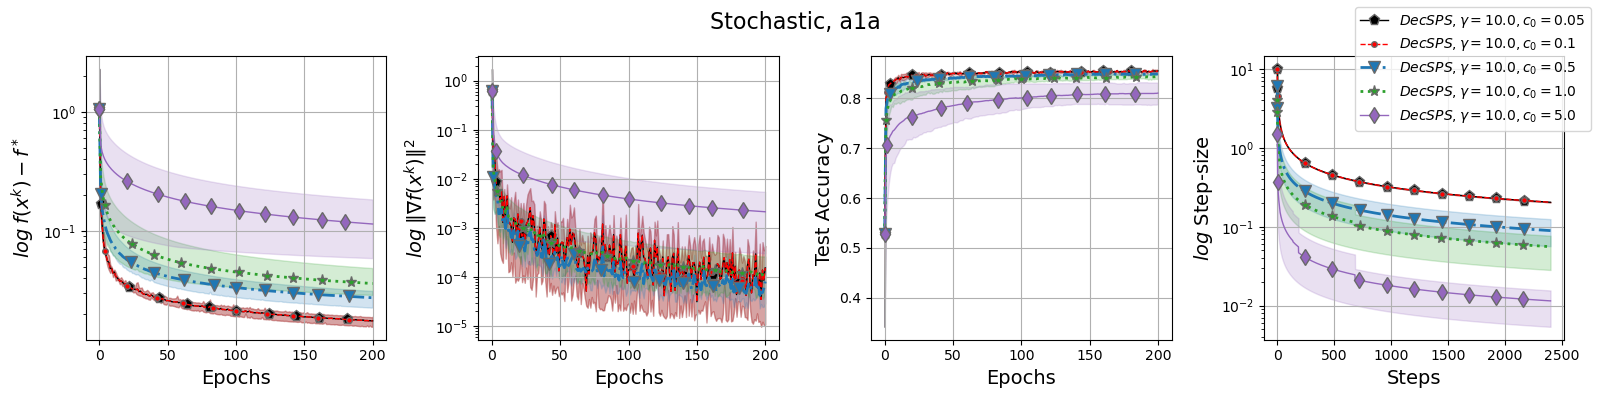

In [77]:
setting = "stochastic"
batch_size = 128
dataset_name = "a1a"

n_epochs = 200

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

eta_max = 10.0
c_0 = 1.0
for c_0 in [0.05, 0.1, 0.5, 1.0, 5.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    labels.append(r"$DecSPS, \gamma={0}, c_0={1}$".format(eta_max, c_0))

with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Epochs", "Epochs", "Epochs", "Steps"],
        y_labels=[r"$log\;f(x^k) - f^*$", r"$log\;\| \nabla f(x^k) \|^2$", "Test Accuracy", r"$log$ Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "train/grad_norm_sq", "test/acc", "lr"],
        y_scales=["log", "log", "linear", "log"],
        threshold=0.0,
        filename=f"{dataset_name}_{setting.lower()}_DecSPS_c0_sensitivity.pdf",
        )

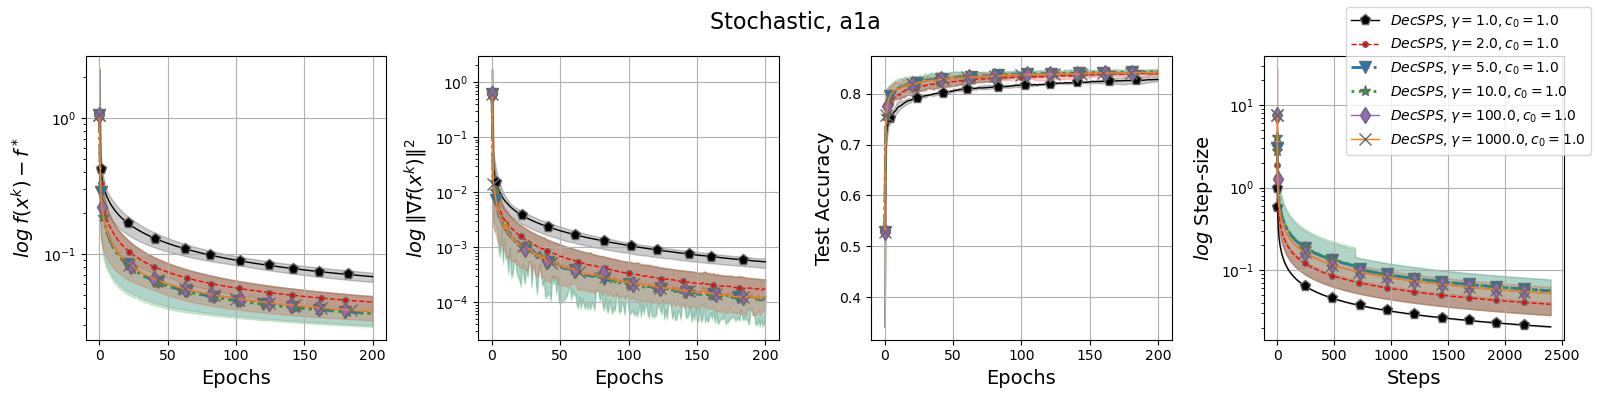

In [76]:
setting = "stochastic"
batch_size = 128
dataset_name = "a1a"

n_epochs = 200

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

eta_max = 10.0
c_0 = 1.0
for eta_max in [1.0, 2.0, 5.0, 10.0, 100.0, 1000.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    labels.append(r"$DecSPS, \gamma={0}, c_0={1}$".format(eta_max, c_0))

with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_labels=["Epochs", "Epochs", "Epochs", "Steps"],
        y_labels=[r"$log\;f(x^k) - f^*$", r"$log\;\| \nabla f(x^k) \|^2$", "Test Accuracy", r"$log$ Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "train/grad_norm_sq", "test/acc", "lr"],
        y_scales=["log", "log", "linear", "log"],
        threshold=0.0,
        filename=f"{dataset_name}_{setting.lower()}_DecSPS_etamax_sensitivity.pdf",
        )

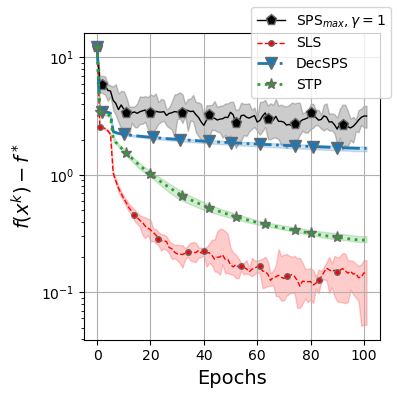

In [259]:
setting = "stochastic"
batch_size = 128
dataset_name = "abalone"
loss_name = "lstsq"

n_epochs = 100

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

for eta_max in [1.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss=loss_name, 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"SPSMAX_{eta_max}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    gamma_b = eta_max
    if eta_max.is_integer():
        gamma_b = round(gamma_b)
    labels.append(r"SPS$_{{max}}, \gamma={0}$".format(gamma_b))
    
seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SLS",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
labels.append(r"SLS")


seed_results = []
eta_max = 10.0
c_0 = 1.0
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
labels.append("DecSPS")

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="STP",
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append("TP")
else:
    labels.append("STP")

with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

plotter_seeds_one_plot(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_label="Epochs",
        y_label=r"$f(x^k) - f^*$",
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"",
        metric="train/loss",
        y_scale="log",
        threshold=0.0,
        filename=f"{dataset_name}_{setting.lower()}_logreg_scaling_sensitivity_1.pdf",
        )

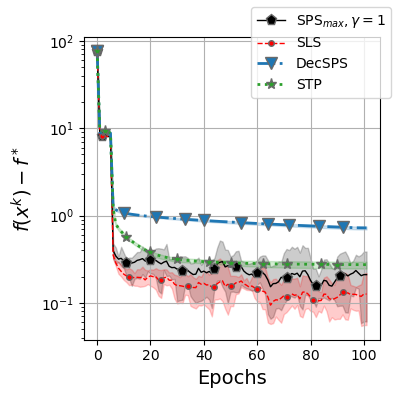

In [263]:
setting = "stochastic"
batch_size = 128
dataset_name = "abalone_scale"
loss_name = "lstsq"

n_epochs = 100

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

for eta_max in [1.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss=loss_name, 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"SPSMAX_{eta_max}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    gamma_b = eta_max
    if eta_max.is_integer():
        gamma_b = round(gamma_b)
    labels.append(r"SPS$_{{max}}, \gamma={0}$".format(gamma_b))
    
seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="SLS",
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
labels.append(r"SLS")


seed_results = []
eta_max = 10.0
c_0 = 1.0
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
labels.append("DecSPS")

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss=loss_name, 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer="STP",
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append("TP")
else:
    labels.append("STP")

with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

plotter_seeds_one_plot(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_label="Epochs",
        y_label=r"$f(x^k) - f^*$",
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"",
        metric="train/loss",
        y_scale="log",
        threshold=0.0,
        filename=f"{dataset_name}_{setting.lower()}_logreg_scaling_sensitivity_2.pdf",
        )

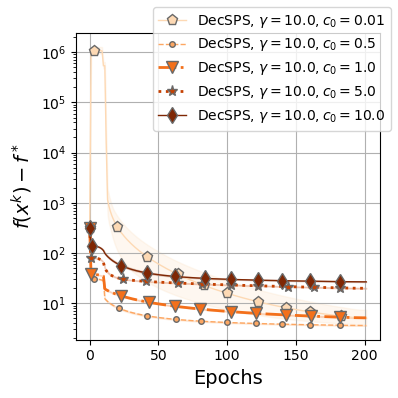

In [216]:
setting = "stochastic"
batch_size = 64
dataset_name = "housing_scale"
loss_name = "lstsq"

n_epochs = 200

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

eta_max = 10.0
c_0 = 1.0
for c_0 in [0.01, 0.5, 1.0, 5.0, 10.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss=loss_name, 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    labels.append(r"DecSPS, $\gamma={0}, c_0={1}$".format(eta_max, c_0))

with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]
    
n_shades = len(histories)
cmap = plt.cm.Oranges
shades = [cmap(i) for i in np.linspace(0.2, 1, n_shades)]

plotter_seeds_one_plot(histories=histories, 
        labels=labels,
        colors=shades,
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_label="Epochs",
        y_label=r"$f(x^k) - f^*$",
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"",
        metric="train/loss",
        y_scale="log",
        threshold=0.0,
        filename=f"{dataset_name}_{setting.lower()}_logreg_DecSPS_sensitivity.pdf",
        )

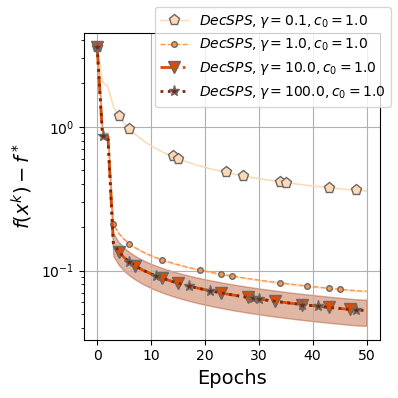

In [243]:
setting = "stochastic"
batch_size = 128
dataset_name = "mushrooms"
loss_name = "logreg"

n_epochs = 50

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

c_0 = 1.0
for eta_max in [0.1, 1.0, 10.0, 100.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss=loss_name, 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    labels.append(r"$DecSPS, \gamma={0}, c_0={1}$".format(eta_max, c_0))

with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

n_shades = len(histories)
cmap = plt.cm.Oranges
shades = [cmap(i) for i in np.linspace(0.2, 1, n_shades)]

plotter_seeds_one_plot(histories=histories, 
        labels=labels,
        colors=shades,
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_label="Epochs",
        y_label=r"$f(x^k) - f^*$",
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"",
        metric="train/loss",
        y_scale="log",
        threshold=0.0,
        # filename=f"{dataset_name}_{setting.lower()}_logreg.pdf",
        )

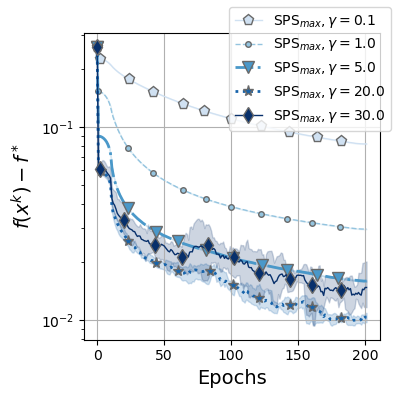

In [212]:
setting = "stochastic"
batch_size = 128
dataset_name = "a1a"
loss_name = "logreg"

n_epochs = 200

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

for eta_max in [0.1, 1.0, 5.0, 20.0, 30.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss=loss_name, 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"SPSMAX_{eta_max}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    labels.append(r"SPS$_{{max}}, \gamma={0}$".format(eta_max))

with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

n_shades = len(histories)
cmap = plt.cm.Blues
shades = [cmap(i) for i in np.linspace(0.2, 1, n_shades)]

plotter_seeds_one_plot(histories=histories, 
        labels=labels,
        colors=shades,
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_label="Epochs",
        y_label=r"$f(x^k) - f^*$",
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"",
        metric="train/loss",
        y_scale="log",
        threshold=0.0,
        filename=f"{dataset_name}_{setting.lower()}_logreg_SPSMAX_sensitivity.pdf",
        )

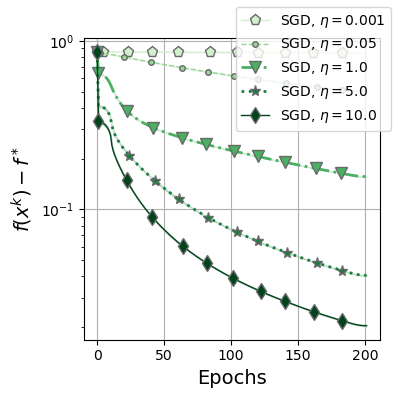

In [206]:
setting = "stochastic"
batch_size = 16
dataset_name = "colon-cancer"
loss_name = "logreg"

n_epochs = 200

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

for lr in [0.001, 0.05, 1.0, 5.0, 10.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss=loss_name, 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"SGD".replace(".", "_"),
                                    lr=f"{lr}".replace(".", "_"),
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    labels.append(r"SGD, $\eta={0}$".format(lr))

with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]
    
train_f_star = np.asarray(0.0)

n_shades = len(histories)
cmap = plt.cm.Greens
shades = [cmap(i) for i in np.linspace(0.2, 1, n_shades)]

plotter_seeds_one_plot(histories=histories, 
        labels=labels,
        colors=shades,
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_label="Epochs",
        y_label=r"$f(x^k) - f^*$",
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"",
        metric="train/loss",
        y_scale="log",
        threshold=0.0,
        filename=f"{dataset_name}_{setting.lower()}_logreg_SGD_sensitivity.pdf",
        )

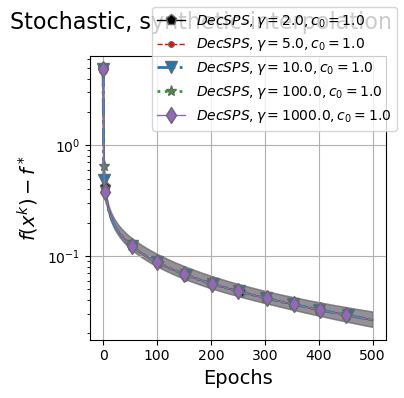

In [193]:
setting = "stochastic"
batch_size = 20
dataset_name = "synthetic-interpolation"

n_epochs = 500

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

eta_max = 10.0
c_0 = 1.0
for eta_max in [2.0, 5.0, 10.0, 100.0, 1000.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    labels.append(r"$DecSPS, \gamma={0}, c_0={1}$".format(eta_max, c_0))

train_f_star = np.asarray(0.0)

plotter_seeds_one_plot(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_label="Epochs",
        y_label=r"$f(x^k) - f^*$",
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metric="train/loss",
        y_scale="log",
        threshold=0.0,
        # filename=f"{dataset_name}_{setting.lower()}_logreg.pdf",
        )

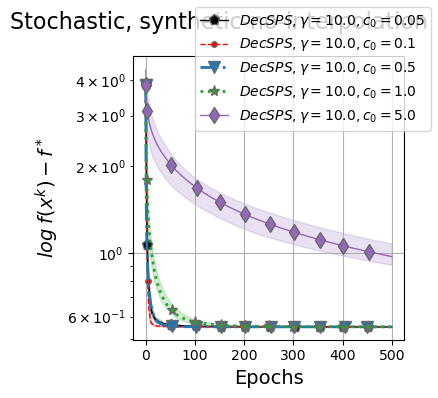

In [58]:
setting = "stochastic"
batch_size = 20
dataset_name = "synthetic-no-interpolation"

n_epochs = 500

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

eta_max = 10.0
c_0 = 1.0
for c_0 in [0.05, 0.1, 0.5, 1.0, 5.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    labels.append(r"$DecSPS, \gamma={0}, c_0={1}$".format(eta_max, c_0))

train_f_star = np.asarray(0.0)

plotter_seeds_one_plot(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_label="Epochs",
        y_label=r"$log\;f(x^k) - f^*$",
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metric="train/loss",
        y_scale="log",
        threshold=0.0,
        # filename=f"{dataset_name}_{setting.lower()}_logreg.pdf",
        )

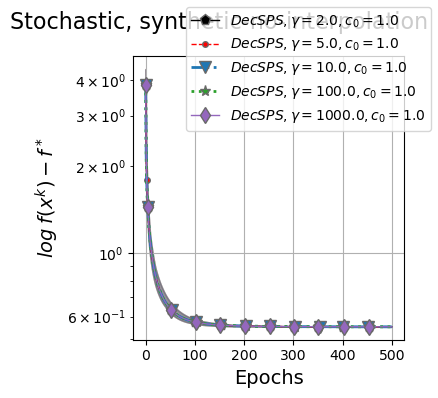

In [62]:
setting = "stochastic"
batch_size = 20
dataset_name = "synthetic-no-interpolation"

n_epochs = 500

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

eta_max = 10.0
c_0 = 1.0
for eta_max in [2.0, 5.0, 10.0, 100.0, 1000.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    labels.append(r"$DecSPS, \gamma={0}, c_0={1}$".format(eta_max, c_0))

train_f_star = np.asarray(0.0)

plotter_seeds_one_plot(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_label="Epochs",
        y_label=r"$log\;f(x^k) - f^*$",
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metric="train/loss",
        y_scale="log",
        threshold=0.0,
        # filename=f"{dataset_name}_{setting.lower()}_logreg.pdf",
        )

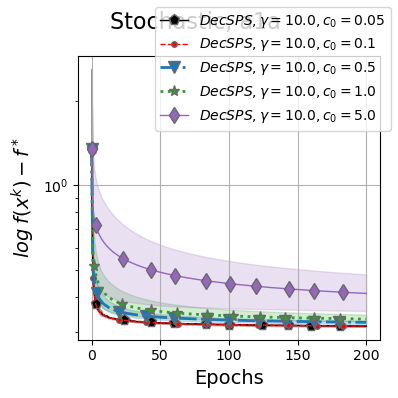

In [65]:
setting = "stochastic"
batch_size = 128
dataset_name = "a1a"

n_epochs = 200

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

eta_max = 10.0
c_0 = 1.0
for c_0 in [0.05, 0.1, 0.5, 1.0, 5.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    labels.append(r"$DecSPS, \gamma={0}, c_0={1}$".format(eta_max, c_0))

train_f_star = np.asarray(0.0)

plotter_seeds_one_plot(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_label="Epochs",
        y_label=r"$log\;f(x^k) - f^*$",
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metric="train/loss",
        y_scale="log",
        threshold=0.0,
        # filename=f"{dataset_name}_{setting.lower()}_logreg.pdf",
        )

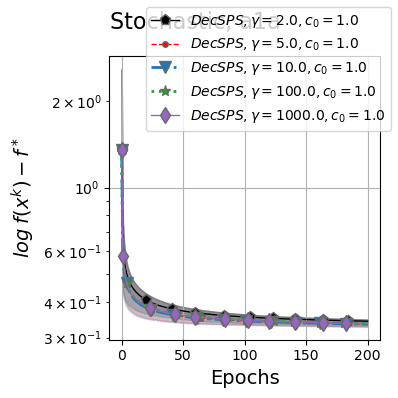

In [66]:
setting = "stochastic"
batch_size = 128
dataset_name = "a1a"

n_epochs = 200

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

eta_max = 10.0
c_0 = 1.0
for eta_max in [2.0, 5.0, 10.0, 100.0, 1000.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    labels.append(r"$DecSPS, \gamma={0}, c_0={1}$".format(eta_max, c_0))

train_f_star = np.asarray(0.0)

plotter_seeds_one_plot(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_label="Epochs",
        y_label=r"$log\;f(x^k) - f^*$",
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metric="train/loss",
        y_scale="log",
        threshold=0.0,
        # filename=f"{dataset_name}_{setting.lower()}_logreg.pdf",
        )

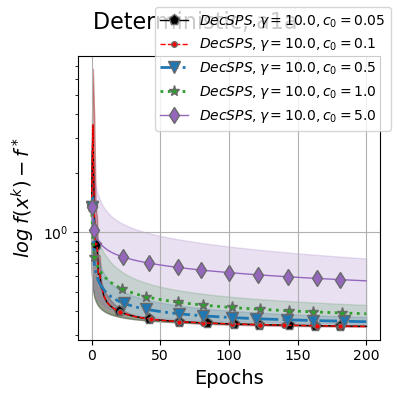

In [67]:
setting = "deterministic"
batch_size = 0
dataset_name = "a1a"

n_epochs = 200

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

eta_max = 10.0
c_0 = 1.0
for c_0 in [0.05, 0.1, 0.5, 1.0, 5.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    labels.append(r"$DecSPS, \gamma={0}, c_0={1}$".format(eta_max, c_0))

train_f_star = np.asarray(0.0)

plotter_seeds_one_plot(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_label="Epochs",
        y_label=r"$log\;f(x^k) - f^*$",
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metric="train/loss",
        y_scale="log",
        threshold=0.0,
        # filename=f"{dataset_name}_{setting.lower()}_logreg.pdf",
        )

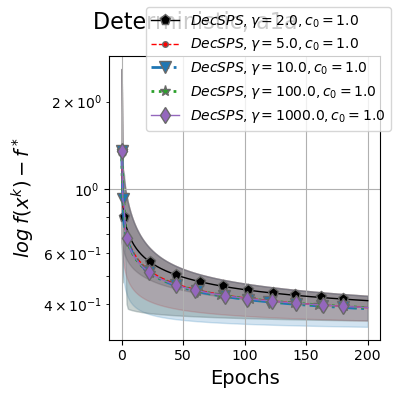

In [68]:
setting = "deterministic"
batch_size = 0
dataset_name = "a1a"

n_epochs = 200

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

eta_max = 10.0
c_0 = 1.0
for eta_max in [2.0, 5.0, 10.0, 100.0, 1000.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"DecSPS_{eta_max}_{c_0}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    labels.append(r"$DecSPS, \gamma={0}, c_0={1}$".format(eta_max, c_0))

train_f_star = np.asarray(0.0)

plotter_seeds_one_plot(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=train_f_star, 
        x_label="Epochs",
        y_label=r"$log\;f(x^k) - f^*$",
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metric="train/loss",
        y_scale="log",
        threshold=0.0,
        # filename=f"{dataset_name}_{setting.lower()}_logreg.pdf",
        )

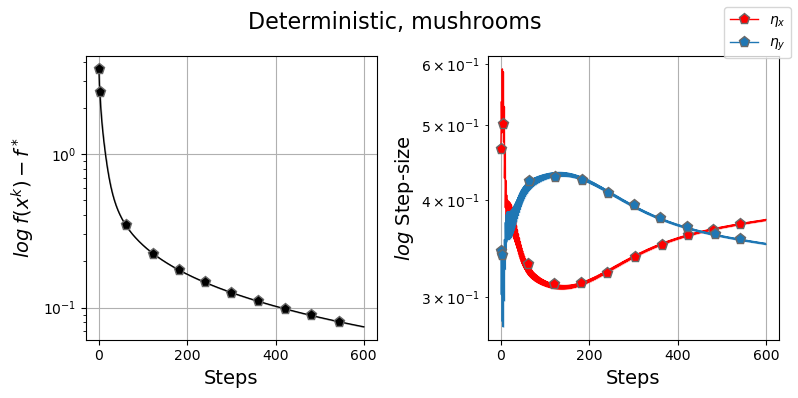

In [109]:
setting = "deterministic"
batch_size = 0
dataset_name = "mushrooms"
n_epochs = 600

histories = []
labels = []

seeds_list = [0, ]

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=0,
                                n_epochs=n_epochs,
                                optimizer="STP",
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append("TP")
else:
    labels.append("STP")

with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"]
linestyles=["-", "--", "-.", ":", "-", "-", "-"]
linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.5]
markers=["p", ".", "v", "*", "d", "x", "X"]
markeredgecolor="dimgrey"
markersize=8
alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8]
f_star=train_f_star
x_labels=["Steps","Steps"]
y_labels=[r"$log\;f(x^k) - f^*$", r"$log$ Step-size"]
x_labels_fs=14
y_labels_fs=14
suptitle=f"{setting.capitalize()}, {dataset_name}"
y_scales=["log", "log"]
threshold=0.0
if len(seeds_list) == 1:
    filename=f"{dataset_name}_{setting.lower()}_tp_stepsize_sequences_1seed.pdf"
else:
    filename=f"{dataset_name}_{setting.lower()}_tp_stepsize_sequences.pdf"
    

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle(suptitle, fontsize=16)
    
for history, label, c, ls, lw, m, alpha in zip(histories, labels, colors, linestyles, linewidths, markers, alphas):

    res = [x["train/loss"] - f_star for x in history]
        
    mean_line, max_line, min_line = mean_max_min(res)
    x = np.linspace(0, len(mean_line) - 1, len(mean_line))
    markevery = [0,] + [x + np.random.randint(0, 5) for x in range(0, len(mean_line) - 5, len(mean_line) // 10)]
    ax[0].fill_between(x, max_line, min_line, color=colors[0], alpha=0.2)
    ax[0].plot(x, mean_line, linestyle=ls, linewidth=lw, color=colors[0], markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)   
    ax[0].set_yscale(y_scales[0])
    
    res = [x["lr_x"] - f_star for x in history]
    mean_line, max_line, min_line = mean_max_min(res)
    x = np.linspace(0, len(mean_line) - 1, len(mean_line))
    markevery = [0,] + [x + np.random.randint(0, 5) for x in range(0, len(mean_line) - 5, len(mean_line) // 10)]
    ax[1].fill_between(x, max_line, min_line, color=colors[1], alpha=0.2)
    ax[1].plot(x, mean_line, label=r"$\eta_x$", linestyle=ls, linewidth=lw, color=colors[1], markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)   
    ax[1].set_yscale(y_scales[1])
    
    res = [x["lr_y"] - f_star for x in history]
    mean_line, max_line, min_line = mean_max_min(res)
    x = np.linspace(0, len(mean_line) - 1, len(mean_line))
    markevery = [0,] + [x + np.random.randint(0, 5) for x in range(0, len(mean_line) - 5, len(mean_line) // 10)]
    ax[1].fill_between(x, max_line, min_line, color=colors[2], alpha=0.2)
    ax[1].plot(x, mean_line, label=r"$\eta_y$", linestyle=ls, linewidth=lw, color=colors[2], markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)   
    ax[1].set_yscale(y_scales[1])
    

for i, xlabel, ylabel in zip(range(4), x_labels, y_labels):
    ax[i].set_xlabel(xlabel, fontsize=x_labels_fs)
    ax[i].set_ylabel(ylabel, fontsize=y_labels_fs)
    ax[i].grid()


fig.legend()

fig.tight_layout()
    
if filename is not None:
    directory = "plots/" + datetime.datetime.today().strftime("%d-%m-%Y")
    if not os.path.exists(directory):
        os.makedirs(directory)
    fig.savefig(directory + "/" + filename)
else:
    fig.show()

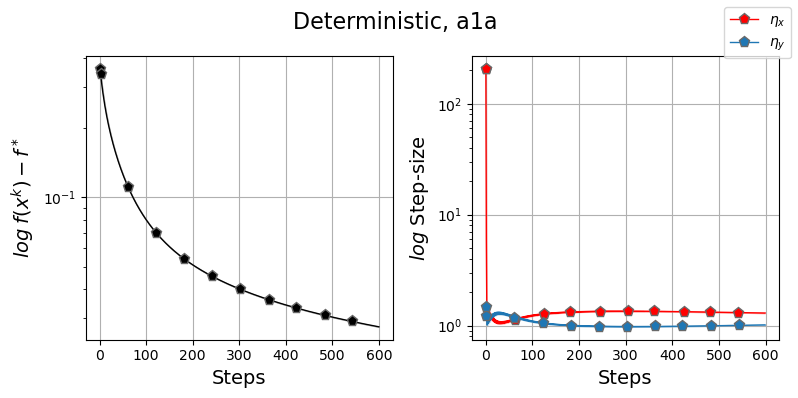

In [108]:
setting = "deterministic"
batch_size = 0
dataset_name = "a1a"
n_epochs = 600

histories = []
labels = []

seeds_list = [0, ]

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=0,
                                n_epochs=n_epochs,
                                optimizer="STP",
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append("TP")
else:
    labels.append("STP")

with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"]
linestyles=["-", "--", "-.", ":", "-", "-", "-"]
linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.5]
markers=["p", ".", "v", "*", "d", "x", "X"]
markeredgecolor="dimgrey"
markersize=8
alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8]
f_star=train_f_star
x_labels=["Steps","Steps"]
y_labels=[r"$log\;f(x^k) - f^*$", r"$log$ Step-size"]
x_labels_fs=14
y_labels_fs=14
suptitle=f"{setting.capitalize()}, {dataset_name}"
y_scales=["log", "log"]
threshold=0.0
if len(seeds_list) == 1:
    filename=f"{dataset_name}_{setting.lower()}_tp_stepsize_sequences_1seed.pdf"
else:
    filename=f"{dataset_name}_{setting.lower()}_tp_stepsize_sequences.pdf"
    
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle(suptitle, fontsize=16)
    
for history, label, c, ls, lw, m, alpha in zip(histories, labels, colors, linestyles, linewidths, markers, alphas):

    res = [x["train/loss"] - f_star for x in history]
        
    mean_line, max_line, min_line = mean_max_min(res)
    x = np.linspace(0, len(mean_line) - 1, len(mean_line))
    markevery = [0,] + [x + np.random.randint(0, 5) for x in range(0, len(mean_line) - 5, len(mean_line) // 10)]
    ax[0].fill_between(x, max_line, min_line, color=colors[0], alpha=0.2)
    ax[0].plot(x, mean_line, linestyle=ls, linewidth=lw, color=colors[0], markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)   
    ax[0].set_yscale(y_scales[0])
    
    res = [x["lr_x"] - f_star for x in history]
    mean_line, max_line, min_line = mean_max_min(res)
    x = np.linspace(0, len(mean_line) - 1, len(mean_line))
    markevery = [0,] + [x + np.random.randint(0, 5) for x in range(0, len(mean_line) - 5, len(mean_line) // 10)]
    ax[1].fill_between(x, max_line, min_line, color=colors[1], alpha=0.2)
    ax[1].plot(x, mean_line, label=r"$\eta_x$", linestyle=ls, linewidth=lw, color=colors[1], markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)   
    ax[1].set_yscale(y_scales[1])
    
    res = [x["lr_y"] - f_star for x in history]
    mean_line, max_line, min_line = mean_max_min(res)
    x = np.linspace(0, len(mean_line) - 1, len(mean_line))
    markevery = [0,] + [x + np.random.randint(0, 5) for x in range(0, len(mean_line) - 5, len(mean_line) // 10)]
    ax[1].fill_between(x, max_line, min_line, color=colors[2], alpha=0.2)
    ax[1].plot(x, mean_line, label=r"$\eta_y$", linestyle=ls, linewidth=lw, color=colors[2], markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)   
    ax[1].set_yscale(y_scales[1])
    

for i, xlabel, ylabel in zip(range(4), x_labels, y_labels):
    ax[i].set_xlabel(xlabel, fontsize=x_labels_fs)
    ax[i].set_ylabel(ylabel, fontsize=y_labels_fs)
    ax[i].grid()


fig.legend()

fig.tight_layout()
    
if filename is not None:
    directory = "plots/" + datetime.datetime.today().strftime("%d-%m-%Y")
    if not os.path.exists(directory):
        os.makedirs(directory)
    fig.savefig(directory + "/" + filename)
else:
    fig.show()

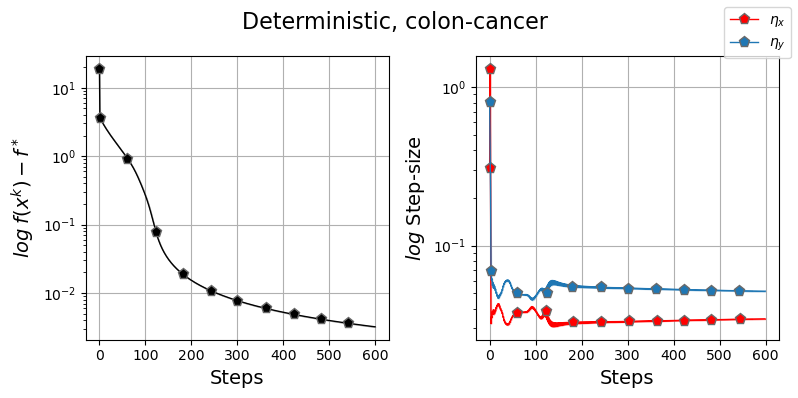

In [107]:
setting = "deterministic"
batch_size = 0
dataset_name = "colon-cancer"
n_epochs = 600

histories = []
labels = []

seeds_list = [0, ]

seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=0,
                                n_epochs=n_epochs,
                                optimizer="STP",
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append("TP")
else:
    labels.append("STP")

with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"]
linestyles=["-", "--", "-.", ":", "-", "-", "-"]
linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.5]
markers=["p", ".", "v", "*", "d", "x", "X"]
markeredgecolor="dimgrey"
markersize=8
alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8]
f_star=train_f_star
x_labels=["Steps","Steps"]
y_labels=[r"$log\;f(x^k) - f^*$", r"$log$ Step-size"]
x_labels_fs=14
y_labels_fs=14
suptitle=f"{setting.capitalize()}, {dataset_name}"
y_scales=["log", "log"]
threshold=0.0
if len(seeds_list) == 1:
    filename=f"{dataset_name}_{setting.lower()}_tp_stepsize_sequences_1seed.pdf"
else:
    filename=f"{dataset_name}_{setting.lower()}_tp_stepsize_sequences.pdf"
    
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle(suptitle, fontsize=16)
    
for history, label, c, ls, lw, m, alpha in zip(histories, labels, colors, linestyles, linewidths, markers, alphas):

    res = [x["train/loss"] - f_star for x in history]
        
    mean_line, max_line, min_line = mean_max_min(res)
    x = np.linspace(0, len(mean_line) - 1, len(mean_line))
    markevery = [0,] + [x + np.random.randint(0, 5) for x in range(0, len(mean_line) - 5, len(mean_line) // 10)]
    ax[0].fill_between(x, max_line, min_line, color=colors[0], alpha=0.2)
    ax[0].plot(x, mean_line, linestyle=ls, linewidth=lw, color=colors[0], markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)   
    ax[0].set_yscale(y_scales[0])
    
    res = [x["lr_x"] - f_star for x in history]
    mean_line, max_line, min_line = mean_max_min(res)
    x = np.linspace(0, len(mean_line) - 1, len(mean_line))
    markevery = [0,] + [x + np.random.randint(0, 5) for x in range(0, len(mean_line) - 5, len(mean_line) // 10)]
    ax[1].fill_between(x, max_line, min_line, color=colors[1], alpha=0.2)
    ax[1].plot(x, mean_line, label=r"$\eta_x$", linestyle=ls, linewidth=lw, color=colors[1], markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)   
    ax[1].set_yscale(y_scales[1])
    
    res = [x["lr_y"] - f_star for x in history]
    mean_line, max_line, min_line = mean_max_min(res)
    x = np.linspace(0, len(mean_line) - 1, len(mean_line))
    markevery = [0,] + [x + np.random.randint(0, 5) for x in range(0, len(mean_line) - 5, len(mean_line) // 10)]
    ax[1].fill_between(x, max_line, min_line, color=colors[2], alpha=0.2)
    ax[1].plot(x, mean_line, label=r"$\eta_y$", linestyle=ls, linewidth=lw, color=colors[2], markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)   
    ax[1].set_yscale(y_scales[1])
    

for i, xlabel, ylabel in zip(range(4), x_labels, y_labels):
    ax[i].set_xlabel(xlabel, fontsize=x_labels_fs)
    ax[i].set_ylabel(ylabel, fontsize=y_labels_fs)
    ax[i].grid()


fig.legend()

fig.tight_layout()
    
if filename is not None:
    directory = "plots/" + datetime.datetime.today().strftime("%d-%m-%Y")
    if not os.path.exists(directory):
        os.makedirs(directory)
    fig.savefig(directory + "/" + filename)
else:
    fig.show()

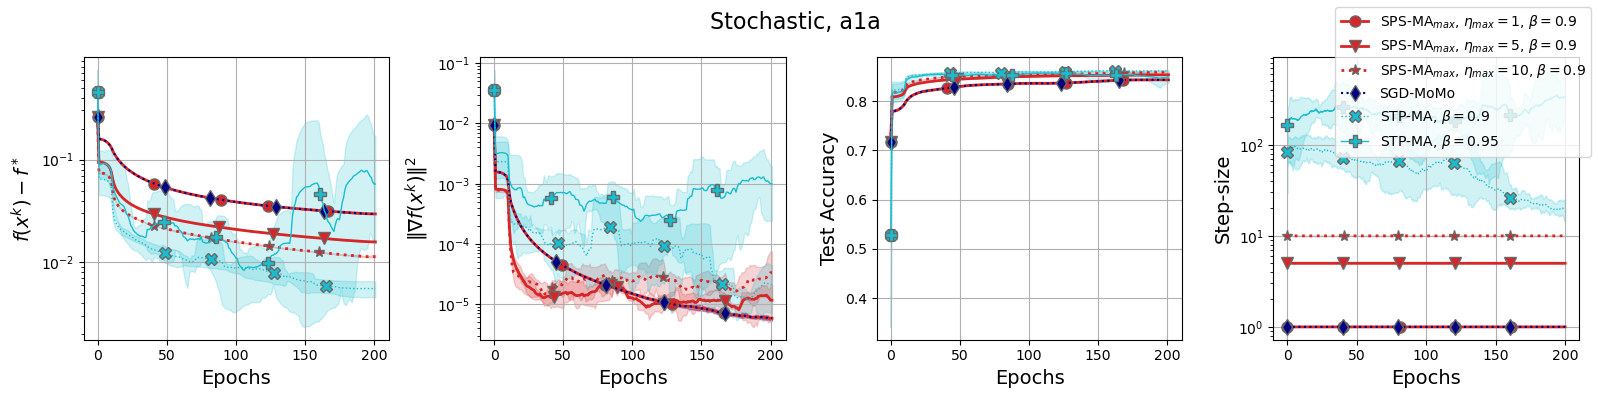

In [297]:
dataset_name = "a1a"
setting = "stochastic"
batch_size=128

n_epochs = 200

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

beta = 0.9
for eta_max in [1.0, 5.0, 10.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"SPS-MA_{eta_max}_{beta}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    gamma_b = eta_max
    if eta_max.is_integer():
        gamma_b = round(gamma_b)
    labels.append(r"SPS-MA$_{{max}}$, $\eta_{{max}}={0}$, $\beta={1}$".format(gamma_b, beta))
    
beta = 0.9
seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer=f"SGD-MoMo_{beta}".replace(".", "_"),
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
labels.append(r"SGD-MoMo")

for beta in [0.9, 0.95]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"STP-MA_{beta}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        seed_results.append(results)
    histories.append(seed_results)
    labels.append(r"STP-MA, $\beta={0}$".format(beta))


with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

plotter_seeds(histories=histories, 
        labels=labels,
        colors=["tab:red", "tab:red", "tab:red", "navy", "tab:cyan", "tab:cyan"],
        linestyles=["-", "-", ":", ":", ":", "-", "-", "-"],
        linewidths=[2.0, 2.0, 2.0, 1.5, 1.0, 1.0],
        markers=["o", "v", "*", "d", "X", "P"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
        f_star=train_f_star, 
        x_labels=["Epochs", "Epochs", "Epochs", "Epochs"],
        y_labels=[r"$f(x^k) - f^*$", r"$\| \nabla f(x^k) \|^2$", "Test Accuracy", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "train/grad_norm_sq", "test/acc", "lr"],
        y_scales=["log", "log", "linear", "log"],
        mov_ave=[True, True, True, True],
        threshold=0.0,
        acc_ylim=None,
        filename=f"ma_{dataset_name}_{setting.lower()}_logreg_4.pdf",
        )

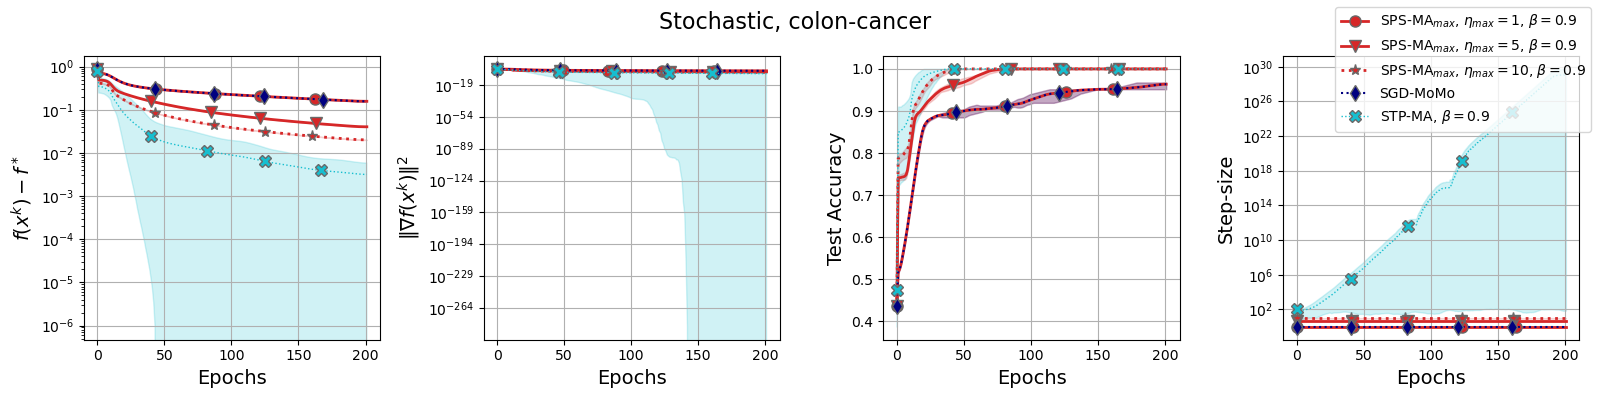

In [305]:
dataset_name = "colon-cancer"
setting = "stochastic"
batch_size=16

n_epochs = 200

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

beta = 0.9
for eta_max in [1.0, 5.0, 10.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"SPS-MA_{eta_max}_{beta}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    gamma_b = eta_max
    if eta_max.is_integer():
        gamma_b = round(gamma_b)
    labels.append(r"SPS-MA$_{{max}}$, $\eta_{{max}}={0}$, $\beta={1}$".format(gamma_b, beta))
    
beta = 0.9
seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer=f"SGD-MoMo_{beta}".replace(".", "_"),
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
labels.append(r"SGD-MoMo")

for beta in [0.9, ]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"STP-MA_{beta}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        seed_results.append(results)
    histories.append(seed_results)
    labels.append(r"STP-MA, $\beta={0}$".format(beta))


with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

plotter_seeds(histories=histories, 
        labels=labels,
        colors=["tab:red", "tab:red", "tab:red", "navy", "tab:cyan", "tab:cyan"],
        linestyles=["-", "-", ":", ":", ":", "-", "-", "-"],
        linewidths=[2.0, 2.0, 2.0, 1.5, 1.0, 1.0],
        markers=["o", "v", "*", "d", "X", "P"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
        f_star=train_f_star, 
        x_labels=["Epochs", "Epochs", "Epochs", "Epochs"],
        y_labels=[r"$f(x^k) - f^*$", r"$\| \nabla f(x^k) \|^2$", "Test Accuracy", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "train/grad_norm_sq", "test/acc", "lr"],
        y_scales=["log", "log", "linear", "log"],
        mov_ave=[True, True, True, True],
        threshold=0.0,
        acc_ylim=None,
        filename=f"ma_{dataset_name}_{setting.lower()}_logreg_4.pdf",
        )

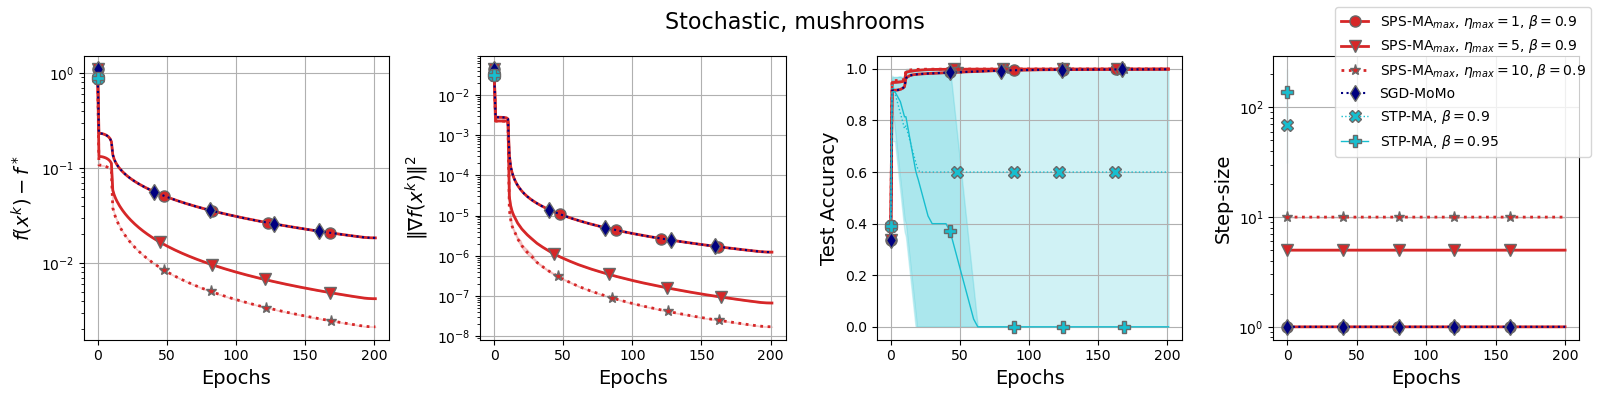

In [303]:
dataset_name = "mushrooms"
setting = "stochastic"
batch_size=128

n_epochs = 200

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

beta = 0.9
for eta_max in [1.0, 5.0, 10.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"SPS-MA_{eta_max}_{beta}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    gamma_b = eta_max
    if eta_max.is_integer():
        gamma_b = round(gamma_b)
    labels.append(r"SPS-MA$_{{max}}$, $\eta_{{max}}={0}$, $\beta={1}$".format(gamma_b, beta))
    
beta = 0.9
seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer=f"SGD-MoMo_{beta}".replace(".", "_"),
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
labels.append(r"SGD-MoMo")

for beta in [0.9, 0.95]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"STP-MA_{beta}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        seed_results.append(results)
    histories.append(seed_results)
    labels.append(r"STP-MA, $\beta={0}$".format(beta))


with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

plotter_seeds(histories=histories, 
        labels=labels,
        colors=["tab:red", "tab:red", "tab:red", "navy", "tab:cyan", "tab:cyan"],
        linestyles=["-", "-", ":", ":", ":", "-", "-", "-"],
        linewidths=[2.0, 2.0, 2.0, 1.5, 1.0, 1.0],
        markers=["o", "v", "*", "d", "X", "P"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
        f_star=train_f_star, 
        x_labels=["Epochs", "Epochs", "Epochs", "Epochs"],
        y_labels=[r"$f(x^k) - f^*$", r"$\| \nabla f(x^k) \|^2$", "Test Accuracy", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "train/grad_norm_sq", "test/acc", "lr"],
        y_scales=["log", "log", "linear", "log"],
        mov_ave=[True, True, True, True],
        threshold=0.0,
        acc_ylim=None,
        filename=f"ma_{dataset_name}_{setting.lower()}_logreg_4.pdf",
        )

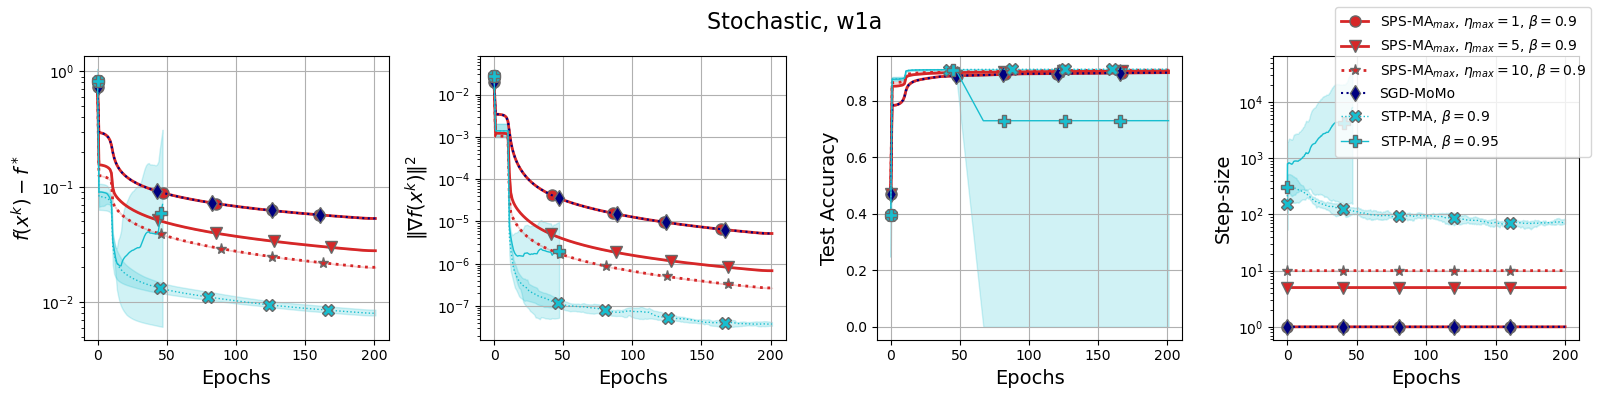

In [300]:
dataset_name = "w1a"
setting = "stochastic"
batch_size=128

n_epochs = 200

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

beta = 0.9
for eta_max in [1.0, 5.0, 10.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"SPS-MA_{eta_max}_{beta}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    gamma_b = eta_max
    if eta_max.is_integer():
        gamma_b = round(gamma_b)
    labels.append(r"SPS-MA$_{{max}}$, $\eta_{{max}}={0}$, $\beta={1}$".format(gamma_b, beta))
    
beta = 0.9
seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer=f"SGD-MoMo_{beta}".replace(".", "_"),
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
labels.append(r"SGD-MoMo")

for beta in [0.9, 0.95]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"STP-MA_{beta}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        seed_results.append(results)
    histories.append(seed_results)
    labels.append(r"STP-MA, $\beta={0}$".format(beta))


with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

plotter_seeds(histories=histories, 
        labels=labels,
        colors=["tab:red", "tab:red", "tab:red", "navy", "tab:cyan", "tab:cyan"],
        linestyles=["-", "-", ":", ":", ":", "-", "-", "-"],
        linewidths=[2.0, 2.0, 2.0, 1.5, 1.0, 1.0],
        markers=["o", "v", "*", "d", "X", "P"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
        f_star=train_f_star, 
        x_labels=["Epochs", "Epochs", "Epochs", "Epochs"],
        y_labels=[r"$f(x^k) - f^*$", r"$\| \nabla f(x^k) \|^2$", "Test Accuracy", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "train/grad_norm_sq", "test/acc", "lr"],
        y_scales=["log", "log", "linear", "log"],
        mov_ave=[True, True, True, True],
        threshold=0.0,
        acc_ylim=None,
        filename=f"ma_{dataset_name}_{setting.lower()}_logreg_4.pdf",
        )

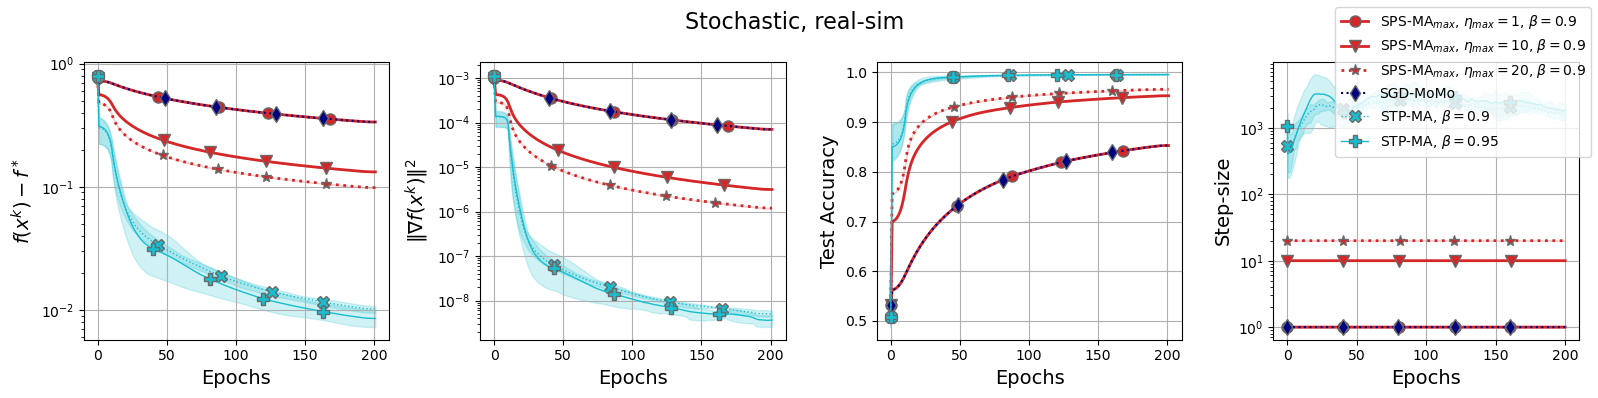

In [302]:
dataset_name = "real-sim"
setting = "stochastic"
batch_size = 8000

n_epochs = 200

histories = []
labels = []

seeds_list = [0, 1, 2, 3, 4]

beta = 0.9
for eta_max in [1.0, 10.0, 20.0]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"SPS-MA_{eta_max}_{beta}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    gamma_b = eta_max
    if eta_max.is_integer():
        gamma_b = round(gamma_b)
    labels.append(r"SPS-MA$_{{max}}$, $\eta_{{max}}={0}$, $\beta={1}$".format(gamma_b, beta))
    
beta = 0.9
seed_results = []
for seed in seeds_list:
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=batch_size,
                                n_epochs=n_epochs,
                                optimizer=f"SGD-MoMo_{beta}".replace(".", "_"),
                                lr="1_0",
                                seed=seed
                                )
    seed_results.append(results)
histories.append(seed_results)
labels.append(r"SGD-MoMo")

for beta in [0.9, 0.95]:
    seed_results = []
    for seed in seeds_list:
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=batch_size,
                                    n_epochs=n_epochs,
                                    optimizer=f"STP-MA_{beta}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        seed_results.append(results)
    histories.append(seed_results)
    labels.append(r"STP-MA, $\beta={0}$".format(beta))


with open(f"solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

plotter_seeds(histories=histories, 
        labels=labels,
        colors=["tab:red", "tab:red", "tab:red", "navy", "tab:cyan", "tab:cyan"],
        linestyles=["-", "-", ":", ":", ":", "-", "-", "-"],
        linewidths=[2.0, 2.0, 2.0, 1.5, 1.0, 1.0],
        markers=["o", "v", "*", "d", "X", "P"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
        f_star=train_f_star, 
        x_labels=["Epochs", "Epochs", "Epochs", "Epochs"],
        y_labels=[r"$f(x^k) - f^*$", r"$\| \nabla f(x^k) \|^2$", "Test Accuracy", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"{setting.capitalize()}, {dataset_name}",
        metrics=["train/loss", "train/grad_norm_sq", "test/acc", "lr"],
        y_scales=["log", "log", "linear", "log"],
        mov_ave=[True, True, True, True],
        threshold=0.0,
        acc_ylim=None,
        filename=f"ma_{dataset_name}_{setting.lower()}_logreg_4.pdf",
        )